# General variables and libraries
Run this cell first

In [1]:
import os
import cld4py
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import colorcet as cc
import matplotlib.patches as mpatches
from patsy import ModelDesc
from statsmodels.formula.api import ols

%matplotlib inline

sns.set_style("ticks")
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.facecolor'] = 'w'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#VARIABLES
BIG = '/home/ty/Big_data/'
TAXS = 'Data/Taxonomy'
TABS = 'Data/Tables'
REPS = 'Data/Repseqs'
META = pd.read_csv('metadata.tsv', sep='\t', index_col=0)
METAM = pd.read_csv('MG-metadata.tsv', sep='\t', index_col=0)
TREES = 'Data/Trees'
CLASS = '../Classifiers/q2_24-10/Silva138_2'
TABLE = f'{TABS}/table.qza'
COREM = f'Results/Core-metrics'
TABLEM = f'{TABS}/MG_table.qza'
BIGOUT = f'{BIG}/Limbiom_16S'
REPSEQS = f'{REPS}/rep-seqs.qza'

ALPHAS = {
    'shannon': "Shannon's entropy",
    'pielou_e': "Pielou's evenness",
    'observed_features': 'Observed ASVs',
}

MDICT = {
    'V1-V2': 'H',
    #'V1-V3': 'X',
    'V3-V4': 's',
    'V4': '*',
}

CDICT = {
     'DNeasy Powerlyzer': 'blue',
     'DNeasy Powersoil': 'darkblue',
     'EZNA Soil': 'green',
     'EZNA Stool': 'darkgreen',
     'FastDNA MP': 'red',
     'FastDNA MP Soil': 'darkred',
     'Maxwell RSC FM': 'orange',
     'QIAamp FDM Stool': 'darkgrey',
     'QIAamp PFP': 'dimgrey',
     'QIAcube FDM Stool': 'yellow',
     'TIANamp Stool': 'tan',
     'Zymo DNA Mini': 'pink',
}

REGS = {
    #'arc': ['CAGYGCASCAGKCGMGAA', 'GGACTACVSGGGTATCTAAT'],
    'V12': ['AGRGTTHGATYMTGGCTCAG', 'TGCTGCCTCCCGTAGGAGT'],
    'V13': ['AGRGTTHGATYMTGGCTCAG', 'ATTACCGCGGCTGCTGG'],
    'V34': ['ACTCCTACGGGAGGCAGCAG', 'GGACTACHVGGGTWTCTAAT'],
    'V4': ['GTGCCAGCMGCCGCGGTAA', 'GGACTACHVGGGTWTCTAAT'],
}

runs = {
    'r1': 'LimBiom_run1_OKG2',
    'r2': 'Limbiom_run2_run3',
    'r3': 'Limbiom_run2_run3',
    'r4': 'LimBiom_run4-5-6-8',
    'r5': 'LimBiom_run4-5-6-8',
    'r6': 'LimBiom_run4-5-6-8',
    'r7': 'LimBiom_run_7_9',
    'r8': 'LimBiom_run4-5-6-8',
    'r9': 'LimBiom_run_7_9',
    'r10': 'LimBiom_run10',
}

BCs = {
    'LimBiom_run1_OKG2': 'Limbiom_run1_metadata.tsv',
    'Limbiom_run2_run3': 'metadata.tsv',
    'LimBiom_run4-5-6-8': 'metadata.tsv',
    'LimBiom_run_7_9': 'bc.tsv',
    'LimBiom_run10': 'bc.tsv',
}

#Kruskal-Wallis + Wilcoxon test
def kw_wx_test(df, col, metric, index, pairs=False, pairwise=False):
    phoc = pd.DataFrame(columns=['Group1', 'Group2', 'Stats', 'p'])
    kw = stats.kruskal(*[g[metric].values for n, g in df.groupby(col)])
    if kw[1] < 0.05 and pairwise == True:
        if pairs == False: 
            pairs = combinations(df[col].unique(), 2)
        for pair in pairs:
            data = df.loc[df[col].isin(pair)].pivot_table(index=[index], columns=col, values=metric)
            r, p = stats.wilcoxon(data[data.columns[0]], data[data.columns[1]], nan_policy='omit')
            phoc.loc[len(phoc)] = [pair[0], pair[1], r, p]
        phoc['q'] = multipletests(phoc.p, method='fdr_bh')[1]
    return kw, phoc
    
#Kruskal-Wallis test
def kw_test(df, col, metric, pairs=False, pairwise=False):
    phoc = pd.DataFrame(columns=['Group1', 'Group2', 'Mean1', 'Mean2', 'Stats', 'p'])
    kw = stats.kruskal(*[g[metric].values for n, g in df.groupby(col)])
    if kw[1] <= 0.05 and pairwise == True:
        if pairs == False: 
            pairs = combinations(df[col].unique(), 2)
        for pair in pairs:
            one = df.loc[df[col] == pair[0], metric].tolist()
            two = df.loc[df[col] == pair[1], metric].tolist()
            if min(one) == max(one) == min(two) == max(two) == 0:
                continue
            r, p = stats.kruskal(one, two)
            phoc.loc[len(phoc)] = [pair[0], pair[1], np.average(one), np.average(two), r, p]
        phoc['q'] = multipletests(phoc.p, method='fdr_bh')[1]
    return kw, phoc

POOL = ['MG'] + list(MDICT.keys())

!mkdir -p {TABS} {REPS} {TAXS} {TREES} {BIGOUT} {COREM} Results Figures

## Install dependencies

In [2]:
!pip install colorcet
!pip install cld4py --upgrade

In [ ]:
!conda env update --file https://raw.githubusercontent.com/caporaso-lab/q2-boots/refs/heads/main/environment-files/q2-boots-qiime2-amplicon-2025.4.yml

In [ ]:
!qiime dev refresh-cache

## Edit metadata file

In [17]:
META.Run = META.Run.str.split('_').str[-1].str.replace('run', 'r')
META['Region'] = META.Region.str.replace('_', '-')
META['Run_Reg'] = META.Run +'_'+ META.Region.str.replace('-V', '')
META['Mother'] = 'M' + META.Mother.str.replace('M', '')
META.to_csv('metadata.tsv', sep='\t')

In [17]:
METAM.index = METAM.index.str.replace('k', 'K')
METAM.to_csv('metadata_met.tsv', sep='\t')

In [ ]:
kits = {
    'QIAamp Powerfecal Pro':                'QIAamp PFP',
    'EZNA Soil Kit':                        'EZNA Soil',
    'Maxwell RSC Fecal Microbiome Kit':     'Maxwell RSC FM',
    'TIANamp Stool DNA Kit':                'TIANamp Stool',
    'Zymo DNA Mini Prep Kit':               'Zymo DNA Mini',
    'QIAcube with FAST DNA Mini Stool Kit': 'QIAcube FDM Stool',
    'EZNA Stool Kit':                       'EZNA Stool',
    'DNeasy Powersoil Pro':                 'DNeasy Powersoil',
    'DNeasy Powerlyzer Powersoil':          'DNeasy Powerlyzer',
    'QIAamp Fast DNA Stool Mini Kit':       'QIAamp FDM Stool',
    'Fast DNA Kit for Soil (MP)':           'FastDNA MP Soil',
    'Fast DNA Kit (MP)':                    'FastDNA MP',
}

#META['Kit_Long'] = META.Kit
META.Kit = META.Kit_Long.map(kits)
META.to_csv('metadata.tsv', sep='\t')
METAM['Kit'] = METAM.Kit_Long.map(kits)
METAM.to_csv('metadata_met.tsv', sep='\t')
display(META, METAM)

# **Working with metadata**

## Description

In [ ]:
for kit in META.Kit.unique():
    print(kit)
    
df = pd.DataFrame()
df.loc['Pigs', 'Count'] = len(META.SID.unique()) 
df.loc['Kits', 'Count'] = len(META['Kit-ID'].unique())
df.loc['Regions', 'Count'] = len(META['Region'].unique())
df.loc['Median_Weight', 'Count'] = META['Weight'].median()
df.loc['Median_Age', 'Count'] = META['Age'].median()

df.to_csv('Results/Metadata_description.csv')
df

## Plot DNA ratios and concentration by kit

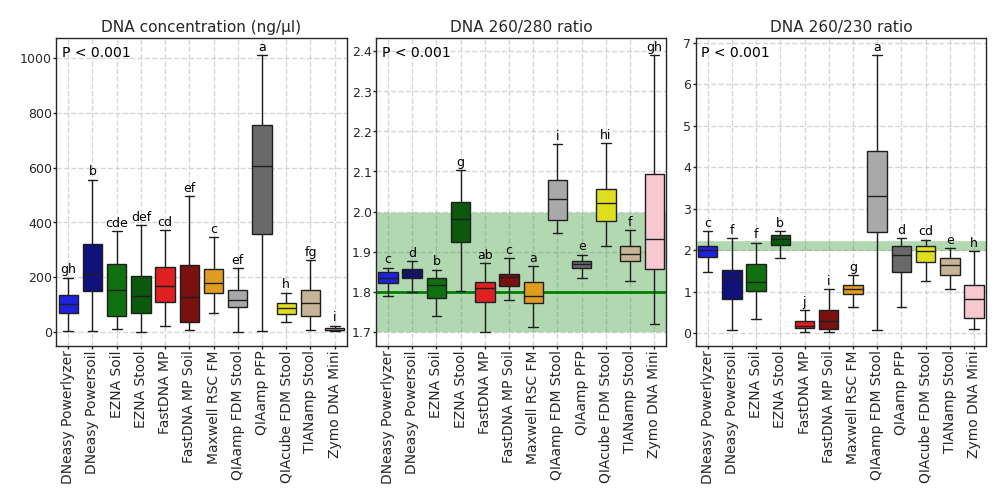

In [65]:
COLS = {
    'DNA_concentration': 'DNA concentration (ng/\u03bcl)',
    'A260/A280': 'DNA 260/280 ratio', 
    'A260/A230': 'DNA 260/230 ratio',
}

ABCsort = {
    'DNA_concentration': 'descending',
    "A260/A280": 'ascending',
    'A260/A230': 'descending', 
}

data = META.drop_duplicates(subset=['Seq-ID'], keep='first').copy()
summary = pd.DataFrame()

#set figure
rows = 1
cols = len(COLS)
fig, axes = plt.subplots(rows, cols, figsize=(6, 2), gridspec_kw={'wspace': .1}, )

for i, col in enumerate(COLS):
    #boxplots
    ax = axes[i]
    sns.boxplot(x='Kit', y=col, data=data, ax=ax, palette=CDICT, order=CDICT,
                linewidth=.5, fliersize=.5, showfliers=False)

    if col == 'A260/A280':
        ax.axhline(y=1.85, color='green', linestyle='-', zorder=.8, lw=43, alpha=0.3, )
        ax.axhline(y=1.8, color='green', linestyle='-', zorder=.8, lw=1, alpha=1)
    if col == 'A260/A230':
        ax.axhline(y=2.1, color='green', linestyle='-', zorder=.8, lw=3.5, alpha=0.3)
    ax.tick_params(axis='both', labelsize=4.5, pad=.5, length=1, width=0.5)
    ax.tick_params(axis='x', labelsize=5, rotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(lw=.5, ls='--', alpha=0.8, axis='both') 
    ax.text(.5, 1.02, COLS[col], ha='center', fontsize=5.5, transform=ax.transAxes)
    
    #stats
    kw, phoc = kw_wx_test(data, 'Kit', col, 'SID', pairwise=True)
    if kw[1] < 0.05:
        for ind in phoc.index:
            i = len(summary)
            summary.loc[i, 'Metric'] = col
            summary.loc[i, ['KW_WX', 'Stats']] = kw[1], kw[0]
            summary.loc[i, ['Group1', 'Group2']] = phoc.loc[ind, ['Group1', 'Group2']]
            summary.loc[i, ['p', 'q']] = phoc.loc[ind, ['p', 'q']]
    else:
        i = len(summary)
        summary.loc[i, 'Metric'] = col
        summary.loc[i, ['KW_WX', 'Stats']] = kw[1], kw[0]
        summary.loc[i, ['Group1', 'Group2', 'p', 'q']] = '-', '-', '-', '-'

    # add P-general
    summ = summary.loc[summary.Metric == col]
    p_gen = round(summ.KW_WX.iloc[0], 3)
    p = f'P = {p_gen}'
    if p_gen == 0:
        p = f'P < 0.001'
    c = 'black' if p_gen < .05 else 'dimgrey'
    ax.text(.02, .94, p, ha='left', fontsize=5, transform=ax.transAxes, c=c)

    #cld
    summ = summ.loc[summ.q != '-']
    cld = cld4py.assign_letters(summ, 'Group1', 'Group2', 'q', order=ABCsort[col], 
                                data=data, vals=col, group='Kit', param=False)
    cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='boxplot', pos='upper', 
               vals=col, group='Kit', pad=.5, c='black', fs=4.5, lim=1)

out_stats, out_figs = 'Results/DNA_stats', 'Figures/DNA'

!mkdir -p {out_stats} {out_figs}

summary.to_csv(f'{out_stats}/DNA_dependent.tsv', sep='\t')
plt.savefig(f'{out_figs}/DNA.svg')
plt.savefig(f'{out_figs}/DNA.png')

## Descriptive stats

In [ ]:
COLS = {
    'DNA_concentration': 'DNA concentration (ng/\u03bcl)',
    'A260/A280': 'DNA 260/280 ratio', 
    'A260/A230': 'DNA 260/230 ratio',
}
out_stats, out_figs = 'Results/DNA_stats', 'Figures/DNA'

meta = META.drop_duplicates(subset=['Seq-ID'], keep='first').copy()
dfs = []

for i, col in enumerate(COLS):
    for kit in CDICT:
        data = meta.loc[meta.Kit == kit]
        desc = pd.DataFrame(data[col].describe()).T.reset_index(names='Factor')
        desc['Kit'] = kit
        dfs.append(desc)
    
df = pd.concat(dfs, ignore_index=True)
df['mean'] = df['mean'].apply(lambda x: round(x, 3))
df['median'] = df['50%'].apply(lambda x: round(x, 3))
df['IQR'] = df['75%'] - df['25%']
df['IQR'] = df['IQR'].apply(lambda x: round(x, 3))
df['std'] = df['std'].apply(lambda x: round(x, 3))
df = df[[c for c in df.columns if '%' not in c]]
df.to_csv(f'{out_stats}/DNA_Descriptive.tsv', sep='\t', index=False)
display(df)

# **Qiime2 16S**

## Importing and denoising

### Import to Qiime2

In [ ]:
!mkdir -p Data/Demux

for rr in META.Run_Reg.unique():
    r = rr.split('_')[0]
    meta = META.loc[META.Run_Reg==rr]
    demux = f'{BIG}/{runs[r]}/Demux/Limbiom'

    #manifest
    samples = [s for s in os.listdir(demux) if '_R1_' in s and s.split('_')[0] in meta.index.tolist()]
    man = pd.DataFrame(data={
        'sample-id': [s.split('_')[0] for s in samples],
        'forward-absolute-filepath': [f'{demux}/{s}' for s in samples],
        'reverse-absolute-filepath': [f'{demux}/{s.replace("_R1_", "_R2_")}' for s in samples]
    })
    man.to_csv(f'Data/Demux/manifest_{rr}.tsv', sep='\t', index=False)

    #import
    !qiime tools import \
        --type 'SampleData[PairedEndSequencesWithQuality]' \
        --input-path Data/Demux/manifest_{rr}.tsv \
        --input-format 'PairedEndFastqManifestPhred33V2' \
        --output-path {BIGOUT}/{rr}-demux.qza

    !qiime demux summarize \
        --i-data {BIGOUT}/{rr}-demux.qza \
        --o-visualization Data/Demux/{rr}-demux.qzv

### Cutadapt

In [ ]:
!mkdir -p Data/Cutadapt

for rr in META.Run_Reg.unique():
    reg = rr.split('_')[-1]
    fwd = REGS[reg][0]
    rvs = REGS[reg][1]
        
    !qiime cutadapt trim-paired \
        --i-demultiplexed-sequences {BIGOUT}/{rr}-demux.qza \
        --o-trimmed-sequences {BIGOUT}/{rr}-cutadapt.qza \
        --p-cores 8 \
        --p-front-f {fwd} \
        --p-front-r {rvs} \
        --p-match-adapter-wildcards \
        --p-discard-untrimmed \
        --p-match-read-wildcards

    !qiime demux summarize \
        --i-data {BIGOUT}/{rr}-cutadapt.qza \
        --o-visualization Data/Cutadapt/{rr}-cutadapt.qzv

In [ ]:
def demux_overview(qzv):  
    a = !unzip $qzv
    out = a[1].split('/')[0].replace('  inflating: ', '')
    df = pd.read_html(f'{out}/data/overview.html', index_col=0)[0]
    !rm -rf $out
    return df.astype(int)

#after cutadapt
dems = []
for rr in META.Run_Reg.unique():
    qzv = f'Data/Cutadapt/{rr}-cutadapt.qzv'
    dem = demux_overview(qzv)
    dem = dem[['forward reads']]
    dem.columns = [rr]
    dems.append(dem)

all_runs = pd.concat(dems, axis=1).T
all_runs.to_csv('Data/Demux/Runs_overview_cutadapt.csv')
all_runs

### Dada2

In [ ]:
#dada2 for all Runs/regions
!mkdir -p Data/Dada2

for rr in META.Run_Reg.unique():

    !qiime dada2 denoise-paired \
        --i-demultiplexed-seqs {BIGOUT}/{rr}-cutadapt.qza \
        --p-trunc-len-f 0 \
        --p-trunc-len-r 0 \
        --p-n-threads 0 \
        --p-max-ee-f 10 \
        --p-max-ee-r 10 \
        --p-min-overlap 4 \
        --o-table Data/Dada2/{rr}-table.qza \
        --o-representative-sequences Data/Dada2/{rr}-rep_seqs.qza \
        --o-denoising-stats Data/Dada2/{rr}-stats.qza

    !qiime feature-table tabulate-seqs \
        --i-data Data/Dada2/{rr}-rep_seqs.qza \
        --o-visualization Data/Dada2/{rr}-rep_seqs.qzv

    !qiime metadata tabulate \
        --m-input-file Data/Dada2/{rr}-stats.qza \
        --o-visualization Data/Dada2/{rr}-stats.qzv

    !qiime feature-table summarize \
        --i-table Data/Dada2/{rr}-table.qza \
        --o-visualization Data/Dada2/{rr}-table.qzv

In [ ]:
#dada2 for V13
#I modified this line:
#449 mergers[[j]] <- mergePairs(ddsF[[j]], drpF, ddsR[[j]], drpR, minOverlap=minOverlap)
#as (modified to force concatenation instead of merging)
#450 mergers[[j]] <- mergePairs(ddsF[[j]], drpF, ddsR[[j]], drpR, justConcatenate=TRUE) 

!mkdir -p Data/Dada2_V13

for rr in META.Run_Reg.unique():
    if "_V13" not in rr:
        continue

    !qiime dada2 denoise-paired \
        --i-demultiplexed-seqs {BIGOUT}/{rr}-cutadapt.qza \
        --p-trunc-len-f 0 \
        --p-trunc-len-r 0 \
        --p-n-threads 0 \
        --p-max-ee-f 10 \
        --p-max-ee-r 10 \
        --o-table Data/Dada2_V13/{rr}-table.qza \
        --o-representative-sequences Data/Dada2_V13/{rr}-rep_seqs.qza \
        --o-denoising-stats Data/Dada2_V13/{rr}-stats.qza

    !qiime feature-table tabulate-seqs \
        --i-data Data/Dada2_V13/{rr}-rep_seqs.qza \
        --o-visualization Data/Dada2_V13/{rr}-rep_seqs.qzv

    !qiime metadata tabulate \
        --m-input-file Data/Dada2_V13/{rr}-stats.qza \
        --o-visualization Data/Dada2_V13/{rr}-stats.qzv

    !qiime feature-table summarize \
        --i-table Data/Dada2_V13/{rr}-table.qza \
        --o-visualization Data/Dada2_V13/{rr}-table.qzv

## Dada2 stats

### Functions

In [26]:
#extract dada2 stats
def dada2_stats(qzv):  
    a = !unzip $qzv
    out = a[1].split('/')[0].replace('  inflating: ', '')
    df = pd.read_csv(f'{out}/data/metadata.tsv', sep='\t', index_col=0, skiprows=[1])
    !rm -rf $out
    return df

FACTS = {
    #'percentage of input passed filter': 'Filtered',
    'percentage of input merged': 'Merged',
    'chimeras': 'Chimeras',
    'percentage of input non-chimeric': 'Retained',
}

out_stats, out_figs = 'Results/DADA2_stats', 'Figures/DADA2'

!mkdir -p {out_stats} {out_figs}

### Merging

In [ ]:
dadas = []
#merged
for rr in META.Run_Reg.unique():
    qzv = f'Data/Dada2/{rr}-stats.qzv'
    df = dada2_stats(qzv)
    df['Run_Reg'] = rr
    df['Dada2'] = 'Merged'
    dadas.append(df)

#concatenated
for rr in META.Run_Reg.unique():
    if "_V13" not in rr:
        continue
    qzv = f'Data/Dada2_V13/{rr}-stats.qzv'
    df = dada2_stats(qzv)
    df['Run_Reg'] = rr
    df['Dada2'] = 'Concatenated'
    dadas.append(df)
    
dada2s = pd.concat(dadas)
dada2s['chimeras'] = round((dada2s['merged']-dada2s['non-chimeric'])*100/dada2s['merged'], 2)
dada2s = dada2s.rename(columns=FACTS)
dada2s.to_csv(f'{out_stats}/Dada2_stats_raw.csv')
dada2s

### Plot dada2 stats

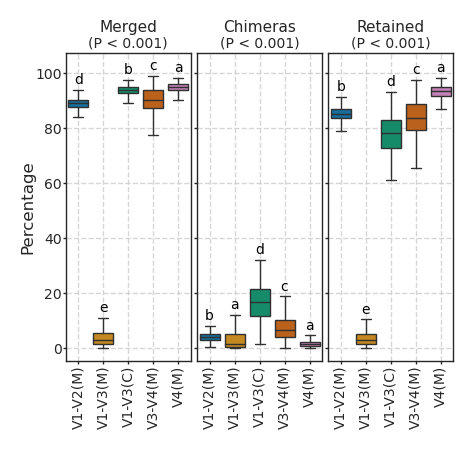

In [67]:
ABCsort = {
    'Merged': 'descending',
    "Chimeras": 'ascending',
    'Retained': 'descending', 
}

dada2s = pd.read_csv(f'{out_stats}/Dada2_stats_raw.csv', index_col=0)
dada2s['Region'] = META['Region']
dada2s = dada2s.sort_values(by=['Region', 'Dada2'], ascending=[True, False])
dada2s['Reg_dada2'] = dada2s['Region'] +'('+ dada2s['Dada2'].str[0] +')'
summary = pd.DataFrame()

#set figure
rows = 1
cols = len(FACTS)
fig, axes = plt.subplots(rows, cols, figsize=(2.5, 2), gridspec_kw={'wspace': .05}, sharey='row')

for i, fact in enumerate(FACTS.values()):
    data = dada2s[(dada2s[fact].notna())]

    #boxplots
    ax = axes[i]
    sns.boxplot(x='Reg_dada2', y=fact, data=data, ax=ax, linewidth=.5, 
                showfliers=False, palette='colorblind')
    
    ax.tick_params(axis='both', labelsize=5, pad=.5, length=1, width=0.5 )
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(lw=.5, ls='--', alpha=0.8) 
    if i == 0:
        ax.set_ylabel('Percentage', fontsize=6, labelpad=0)

    #stats
    kw, phoc = kw_test(data, 'Reg_dada2', fact, pairwise=True)
    if kw[1] < 0.05:
        for ind in phoc.index:
            i = len(summary)
            summary.loc[i, 'Metric'] = fact
            summary.loc[i, ['KW', 'Stats']] = kw[1], kw[0]
            summary.loc[i, ['Group1', 'Group2']] = phoc.loc[ind, ['Group1', 'Group2']]
            summary.loc[i, ['p', 'q']] = phoc.loc[ind, ['p', 'q']]
    else:
        i = len(summary)
        summary.loc[i, 'Metric'] = fact
        summary.loc[i, ['KW', 'Stats']] = kw[1], kw[0]
        summary.loc[i, ['Group1', 'Group2', 'p', 'q']] = '-', '-', '-', '-'
    
    # add P-general
    summ = summary.loc[summary.Metric == fact]
    p_gen = round(summ.KW.iloc[0], 3)
    p = f'P = {p_gen}'
    if p_gen == 0:
        p = f'P < 0.001'
    c = 'black' if p_gen < .05 else 'dimgrey'
    #ax.text(.5, .95, p, size=5, c=c, transform=ax.transAxes, ha='center')
    ax.text(.5, 1.07, fact, ha='center', fontsize=5.5, transform=ax.transAxes)
    ax.text(.5, 1.02, f'({p})', ha='center', fontsize=5, transform=ax.transAxes)

    #cld
    summ = summ.loc[summ.q != '-']
    cld = cld4py.assign_letters(summ, 'Group1', 'Group2', 'q', order=ABCsort[fact], 
                                data=data, vals=fact, group='Reg_dada2', param=False)
    cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='boxplot', pos='upper', 
               vals=fact, group='Reg_dada2', pad=1, c='black', fs=5, lim=1)
   # ax.set_ylim(0, 109)
    
summary.to_csv(f'{out_stats}/KW_dada2s.tsv', sep='\t')
plt.savefig(f'{out_figs}/Dada2_stats.svg')
plt.savefig(f'{out_figs}/Dada2_stats.png')

### Descriptive stats

In [ ]:
dfs = []
dada2s = pd.read_csv(f'{out_stats}/Dada2_stats_raw.csv', index_col=0)
dada2s['Region'] = META['Region']
dada2s = dada2s.sort_values(by=['Region', 'Dada2'], ascending=[True, False])
dada2s['Reg_dada2'] = dada2s['Region'] +'('+ dada2s['Dada2'].str[0] +')'

for i, fact in enumerate(FACTS.values()):
    for reg in dada2s.Reg_dada2.unique():
        data = dada2s[(dada2s[fact].notna()) & (dada2s['Reg_dada2'] == reg)]
        desc = pd.DataFrame(data[fact].describe()).T.reset_index(names='Factor')
        desc['Region'] = reg
        dfs.append(desc)
    
df = pd.concat(dfs, ignore_index=True)
df['mean'] = df['mean'].apply(lambda x: round(x, 3))
df['median'] = df['50%'].apply(lambda x: round(x, 3))
df['IQR'] = df['75%'] - df['25%']
df['IQR'] = df['IQR'].apply(lambda x: round(x, 3))
df['std'] = df['std'].apply(lambda x: round(x, 3))
df = df[[c for c in df.columns if '%' not in c]]
df.to_csv(f'{out_stats}/Dada2_Descriptive.tsv', sep='\t', index=False)
display(df)

## Merge different runs

In [ ]:
# merge all regions from Dada2, but V13 from Dada2_V13 (concat)
tabs, reps = [], []
for rr in META.Run_Reg.unique():
    if "_V13" in rr:
        tabs.append(f'Data/Dada2_V13/{rr}-table.qza')
        reps.append(f'Data/Dada2_V13/{rr}-rep_seqs.qza')
    else:
        tabs.append(f'Data/Dada2/{rr}-table.qza')
        reps.append(f'Data/Dada2/{rr}-rep_seqs.qza')

tables = ' '.join(tabs)
repseqs = ' '.join(reps)

!qiime feature-table merge \
    --i-tables {tables} \
    --o-merged-table {TABLE}

!qiime feature-table merge-seqs \
    --i-data {repseqs} \
    --o-merged-data {REPSEQS}

!qiime feature-table summarize \
    --i-table {TABLE}
    --o-visualization {TABS}/dada2_pooled_table.qzv

## First filtering to remove rare features and extra samples

In [ ]:
#by frequency and prevalence
!qiime feature-table filter-features \
    --i-table {TABLE} \
    --p-min-frequency 10 \
    --p-min-samples 2 \
    --o-filtered-table {TABLE}

#summarize table
!qiime feature-table summarize \
    --i-table {TABLE} \
    --o-visualization {TABS}/frq10_smpl2_pooled_table.qzv

#filter rep-seqs
!qiime feature-table filter-seqs \
    --i-data {REPSEQS} \
    --i-table {TABLE} \
    --o-filtered-data {REPSEQS}

## Separate tables and rep-seqs by the region

### Functions

In [78]:
#extract unique
def tabs_stats(qzv):  
    a = !unzip $qzv
    out = a[1].split('/')[0].replace('  inflating: ', '')
    with open(f'{out}/data/index.html') as html:
        a = html.read().split('features");\n  numberOfFeatures.innerText = formatter.format(')[-1]
        unique = a.split(')')[0]
    !rm -rf $out
    return int(unique)

### Filtering

In [ ]:
for reg in MDICT:
    retain = f"[Region]='{reg}'"

    #filter by region
    !qiime feature-table filter-samples \
        --i-table {TABLE} \
        --m-metadata-file metadata.tsv \
        --p-where "$retain" \
        --o-filtered-table {TABS}/{reg}_table.qza

    #summarize table
    !qiime feature-table summarize \
        --i-table {TABS}/{reg}_table.qza \
        --o-visualization {TABS}/{reg}_frq10_smpl2_table.qzv

    #filter rep-seqs
    !qiime feature-table filter-seqs \
        --i-data {REPSEQS} \
        --i-table {TABS}/{reg}_table.qza \
        --o-filtered-data {REPS}/{reg}_rep-seqs.qza

### Plot ASVs

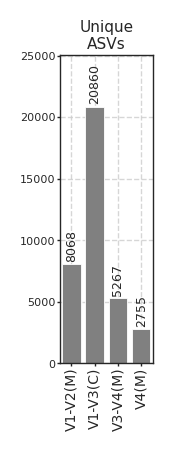

In [81]:
uni_df = pd.DataFrame()

mdict = {
    'V1-V2': 'H',
    'V1-V3': 'X',
    'V3-V4': 's',
    'V4': '*',
}

for reg in mdict:
    unique = tabs_stats(f'Data/Tables/{reg}_frq10_smpl2_table.qzv')
    uni_df.loc[reg, 'Unique_ASVs'] = unique
    uni_df.loc[reg, 'Reg_Dada2'] = f'{reg}(M)' if reg != 'V1-V3' else f'{reg}(C)'

uni_df.to_csv(f'{out_stats}/Region_tabs_stats.csv')

#set figure
rows = 1
cols = 1
fig, ax = plt.subplots(rows, cols, figsize=(0.6, 2))

#barplots
sns.barplot(x='Reg_Dada2', y='Unique_ASVs', data=uni_df, ax=ax, linewidth=0.3, color='grey')

ax.tick_params(axis='both', labelsize=4, pad=.5, length=1, width=0.5 )
ax.tick_params(axis='x', labelsize=5, rotation=90)
ax.set_ylabel('', fontsize=6, labelpad=3)
ax.set_xlabel('')
ax.set_ylim(0, uni_df.Unique_ASVs.max()*1.2)
ax.grid(lw=.5, ls='--', alpha=0.8)
for i, container in enumerate(ax.containers):
        ax.bar_label(container, fmt='%.0f', fontsize=4.5, padding=1, rotation=90)
ax.text(.5, 1.02, 'Unique\nASVs', ha='center', fontsize=5.5, transform=ax.transAxes)

plt.savefig(f'{out_figs}/Unique_ASVs.svg')
plt.savefig(f'{out_figs}/Unique_ASVs.png')

## Taxonomy analyses

### Classification

In [ ]:
for reg in MDICT:
    r = reg.replace('-V', '')

    !qiime feature-classifier classify-hybrid-vsearch-sklearn \
        --i-query {REPS}/{reg}_rep-seqs.qza \
        --i-reference-reads {CLASS}/seqs-{r}.qza \
        --i-reference-taxonomy {CLASS}/taxa-{r}.qza \
        --i-classifier {CLASS}/classifier-{r}.qza \
        --p-threads 12 \
        --p-no-prefilter \
        --o-classification {TAXS}/{reg}_taxonomy.qza
    
    !qiime metadata tabulate \
        --m-input-file {TAXS}/{reg}_taxonomy.qza \
        --o-visualization {TAXS}/{reg}_taxonomy.qzv

### Taxabarplots

In [ ]:
!mkdir -p Results/Taxabarplots

for reg in MDICT:

    !qiime taxa barplot \
        --i-table {TABS}/{reg}_table.qza \
        --i-taxonomy {TAXS}/{reg}_taxonomy.qza \
        --m-metadata-file metadata.tsv \
        --o-visualization Results/Taxabarplots/{reg}_taxabarplot.qzv

## Diversity

### Second filtering to remove unwanted features

In [ ]:
for reg in MDICT:
    
    #by domain
    !qiime taxa filter-table \
        --i-table {TABS}/{reg}_table.qza \
        --i-taxonomy {TAXS}/{reg}_taxonomy.qza \
        --p-include d__Bacteria \
        --o-filtered-table {TABS}/{reg}_table.qza
    
    #remove organelles
    !qiime taxa filter-table \
        --i-table {TABS}/{reg}_table.qza \
        --i-taxonomy {TAXS}/{reg}_taxonomy.qza \
        --p-exclude mitochondria,chloroplast,Cyanobacteria \
        --o-filtered-table {TABS}/{reg}_table.qza
    
    #samples by features depth
    !qiime feature-table filter-samples \
        --i-table {TABS}/{reg}_table.qza \
        --p-min-frequency 4000 \
        --o-filtered-table {TABS}/{reg}_table.qza
    
    #summarize
    !qiime feature-table summarize \
        --i-table {TABS}/{reg}_table.qza \
        --o-visualization {TABS}/{reg}_second_filt_table.qzv
    
    #repseqs by feature table
    !qiime feature-table filter-seqs \
        --i-data {REPS}/{reg}_rep-seqs.qza \
        --i-table {TABS}/{reg}_table.qza \
        --o-filtered-data {REPS}/{reg}_rep-seqs.qza

### Plant a tree

In [ ]:
for reg in MDICT:
    
    !qiime phylogeny align-to-tree-mafft-fasttree \
        --i-sequences {REPS}/{reg}_rep-seqs.qza \
        --p-n-threads 12 \
        --o-alignment {TREES}/{reg}_aligned.qza \
        --o-masked-alignment {TREES}/{reg}_masked.qza \
        --o-tree {TREES}/{reg}_unrooted.qza \
        --o-rooted-tree {TREES}/{reg}_tree.qza
    
    !rm {TREES}/{reg}_aligned.qza {TREES}/{reg}_masked.qza {TREES}/{reg}_unrooted.qza

### Alpha rarefaction

In [ ]:
for reg in MDICT:
    
    !qiime diversity alpha-rarefaction \
        --i-table {TABS}/{reg}_table.qza \
        --i-phylogeny {TREES}/{reg}_tree.qza \
        --p-max-depth 10000 \
        --m-metadata-file metadata.tsv \
        --o-visualization Results/{reg}_alpha_rarefaction.qzv

### Core-metrics

In [ ]:
def find_depth(qzv):  
    a = !unzip $qzv
    out = a[1].split('/')[0].replace('  inflating: ', '')
    with open(f'{out}/data/sample-frequency-detail.html') as counts:
        freqs = counts.read().split('{"Frequency":{"')[-1].split('}}')[0]
        d = min([int(f.split('":')[-1]) for f in freqs.split('.0')[:-1]])
    !rm -rf $out
    return int(d)

for reg in MDICT:
    depth = find_depth(f'{TABS}/{reg}_second_filt_table.qzv')

    !qiime boots core-metrics \
        --i-table {TABS}/{reg}_table.qza \
        --i-phylogeny {TREES}/{reg}_tree.qza \
        --p-sampling-depth {depth} \
        --m-metadata-file metadata.tsv \
        --p-n 100 \
        --p-replacement \
        --output-dir {COREM}/{reg}

### Add alpha metrics to metadata file

In [18]:
def add_alpha(qza):  
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    inf = f'{out}/data/alpha-diversity.tsv'
    df = pd.read_csv(inf, sep='\t', index_col=0)
    !rm -rf $out
    return df 

alpha_amp = META.copy()
for reg in MDICT:
    for alpha in ALPHAS:
        data = add_alpha(f'{COREM}/{reg}/alpha_diversities/{alpha}.qza')
        alpha_amp.loc[data.index, alpha] = data.iloc[:, 0]

alpha_amp.to_csv(f'{COREM}/alpha.tsv',sep='\t')

## Core-Microbiome

In [ ]:
outdir = f'Results/Core-Genera'

!mkdir -p $outdir

for reg in MDICT:
    
    #Collapse to genera
    !qiime taxa collapse \
        --i-table {TABS}/{reg}_table.qza \
        --i-taxonomy {TAXS}/{reg}_taxonomy.qza \
        --p-level 6 \
        --o-collapsed-table {TABS}/{reg}_gen_table.qza
    
    #filer by relative abundances
    !qiime feature-table filter-features-conditionally \
        --i-table {TABS}/{reg}_gen_table.qza \
        --p-abundance .01 \
        --p-prevalence .01 \
        --o-filtered-table {outdir}/{reg}_gen_table.qza

    for kit in CDICT:
        retain = f"[Kit]='{kit}'"
        kit = kit.replace(' ', '_')
        
        #filter by sample type
        !qiime feature-table filter-samples \
            --i-table {outdir}/{reg}_gen_table.qza \
            --m-metadata-file metadata.tsv \
            --p-where "$retain" \
            --o-filtered-table {outdir}/{reg}-{kit}_gen_table.qza
            
        #Core features
        !qiime feature-table core-features \
            --i-table {outdir}/{reg}-{kit}_gen_table.qza \
            --o-visualization {outdir}/{reg}-{kit}_core_gen.qzv

# **Metagenomics**

## Taxonomy analyses

### First filtering to remove rare features and extra samples

In [ ]:
#remove extra samples
!qiime feature-table filter-samples \
    --i-table {TABS}/table_reads_all.qza \
    --m-metadata-file MG-metadata.tsv \
    --o-filtered-table {TABLEM}

#by frequency and prevalence
!qiime feature-table filter-features \
    --i-table {TABLEM} \
    --p-min-frequency 100 \
    --p-min-samples 2 \
    --o-filtered-table {TABLEM}

#summarize table
!qiime feature-table summarize \
    --i-table {TABLEM} \
    --o-visualization {TABS}/frq10_smpl2_MG_table.qzv

### Taxabarplots

In [ ]:
!qiime taxa barplot \
    --i-table {TABLEM} \
    --i-taxonomy {TAXS}/taxonomy_MG.qza \
    --m-metadata-file MG-metadata.tsv \
    --o-visualization Results/Taxabarplots/MG_taxabarplot.qzv

## Diversity

### Second filtering to remove unwanted features

In [ ]:
#by domain
!qiime taxa filter-table \
    --i-table {TABLEM} \
    --i-taxonomy {TAXS}/taxonomy_MG.qza \
    --p-include d__Bacteria \
    --o-filtered-table {TABLEM}

#remove organelles
!qiime taxa filter-table \
    --i-table {TABLEM} \
    --i-taxonomy {TAXS}/taxonomy_MG.qza \
    --p-exclude mitochondria,chloroplast,Cyanobacteria \
    --o-filtered-table {TABLEM}

#samples by features depth
!qiime feature-table filter-samples \
    --i-table {TABLEM} \
    --p-min-frequency 4000 \
    --o-filtered-table {TABLEM}

#summarize
!qiime feature-table summarize \
    --i-table {TABLEM} \
    --o-visualization {TABS}/MG_second_filt_table.qzv

### Core-metrics

In [ ]:
def find_depth(qzv):  
    a = !unzip $qzv
    out = a[1].split('/')[0].replace('  inflating: ', '')
    with open(f'{out}/data/sample-frequency-detail.html') as counts:
        freqs = counts.read().split('{"Frequency":{"')[-1].split('}}')[0]
        d = min([int(f.split('":')[-1]) for f in freqs.split('.0')[:-1]])
    !rm -rf $out
    return int(d)


depth = find_depth(f'{TABS}/MG_second_filt_table.qzv')

!qiime boots core-metrics \
    --i-table {TABLEM} \
    --p-sampling-depth {depth} \
    --m-metadata-file MG-metadata.tsv \
    --p-n 100 \
    --p-replacement \
    --output-dir {COREM}/MG

### Add alpha metrics to metadata file

In [19]:
def add_alpha(qza):  
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    inf = f'{out}/data/alpha-diversity.tsv'
    df = pd.read_csv(inf, sep='\t', index_col=0)
    !rm -rf $out
    return df 

alpha_amp = pd.read_csv(f'{COREM}/alpha.tsv', sep='\t', index_col=0)
alpha_MG = METAM.copy()
#alpha_MG
for alpha in ALPHAS:
    data = add_alpha(f'{COREM}/MG/alpha_diversities/{alpha}.qza')
    alpha_MG.loc[data.index, alpha] = data.iloc[:, 0]

alpha_MG['Region'] = 'MG'
alpha = pd.concat([alpha_amp, alpha_MG])
alpha.to_csv(f'{COREM}/alpha.tsv', sep='\t')

## KO

### First filtering to remove rare features and extra samples

In [ ]:
#remove extra samples
!qiime feature-table filter-samples \
    --i-table Data/Functions/kegg_ko_table.qza \
    --m-metadata-file MG-metadata.tsv \
    --o-filtered-table Data/Functions/kegg_ko_table_filtered.qza

#by frequency and prevalence
!qiime feature-table filter-features \
    --i-table Data/Functions/kegg_ko_table_filtered.qza \
    --p-min-frequency 100 \
    --p-min-samples 2 \
    --o-filtered-table Data/Functions/kegg_ko_table_filtered.qza

#summarize table
!qiime feature-table summarize \
    --i-table Data/Functions/kegg_ko_table_filtered.qza \
    --o-visualization Data/Functions/kegg_ko_table_filtered.qzv

### Core-metrics KO

In [ ]:
def find_depth(qzv):  
    a = !unzip $qzv
    out = a[1].split('/')[0].replace('  inflating: ', '')
    with open(f'{out}/data/sample-frequency-detail.html') as counts:
        freqs = counts.read().split('{"Frequency":{"')[-1].split('}}')[0]
        d = min([int(f.split('":')[-1]) for f in freqs.split('.0')[:-1]])
    !rm -rf $out
    return int(d)


depth = find_depth(f'Data/Functions/kegg_ko_table.qzv')

!qiime boots core-metrics \
    --i-table Data/Functions/kegg_ko_table_filtered.qza \
    --p-sampling-depth {depth} \
    --m-metadata-file MG-metadata.tsv \
    --p-n 100 \
    --p-replacement \
    --output-dir {COREM}/KO

## Core-Microbiome

In [ ]:
outdir = f'Results/Core-Genera'
levs = {
    'gen': 7,
    'sps': 8,
}

!mkdir -p $outdir

for lev, l in levs.items():
    
    #Collapse to taxa
    !qiime taxa collapse \
        --i-table {TABLEM} \
        --i-taxonomy {TAXS}/taxonomy_MG.qza \
        --p-level {l} \
        --o-collapsed-table {TABS}/MG_{lev}_table.qza
    
    #filer by relative abundances
    !qiime feature-table filter-features-conditionally \
        --i-table {TABS}/MG_{lev}_table.qza \
        --p-abundance .01 \
        --p-prevalence .01 \
        --o-filtered-table {outdir}/MG_{lev}_table.qza

    for kit in CDICT:
        retain = f"[Kit]='{kit}'"
        kit = kit.replace(' ', '_')
        
        #filter by sample type
        !qiime feature-table filter-samples \
            --i-table {outdir}/MG_{lev}_table.qza \
            --m-metadata-file MG-metadata.tsv \
            --p-where "$retain" \
            --o-filtered-table {outdir}/MG-{kit}_{lev}_table.qza
            
        #Core features
        !qiime feature-table core-features \
            --i-table {outdir}/MG-{kit}_{lev}_table.qza \
            --o-visualization {outdir}/MG-{kit}_core_{lev}.qzv

## Quast assemblies

### Pool quast results

In [ ]:
dfs = []
for smpl in os.listdir('Data/Quast'):
    if smpl.startswith('.') or os.path.isfile(f"Data/Quast/{smpl}") or int(smpl.split('_')[0][1:]) > 12:
        continue
    df = pd.read_csv(f'Data/Quast/{smpl}/report.tsv', sep='\t', index_col=0)
    dfs.append(df)
quast = pd.concat(dfs, axis=1)
quast.columns = [c.rsplit('_', 1)[0] for c in quast.columns]
quast.index = quast.index.str.replace('# c', 'C')
quast.to_csv('Data/Quast/Summary_report.tsv', sep='\t')
quast

### Plot quast metrics

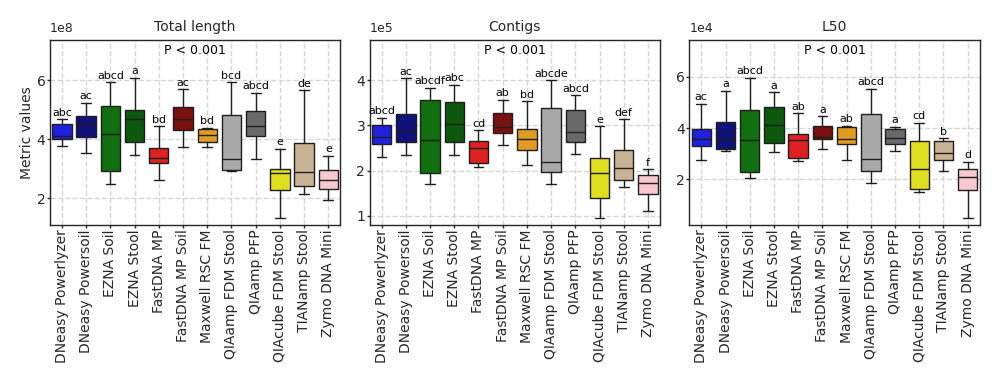

In [23]:
quast = pd.read_csv('Data/Quast/Summary_report.tsv', sep='\t', index_col=0)
#metrics = ['Total length', 'GC (%)', 'Contigs', 'N50', 'L50', 'auN']
metrics = ['Total length', 'Contigs', 'L50']
dfs = []
cols = 3
rows = 1
data = quast.T.copy()
data[['Kit', 'SID']] = METAM[['Kit', 'SID']]

out_stats, out_figs = 'Results/Quast_stats', 'Figures/Quast'

!mkdir -p {out_stats} {out_figs}

fig, axes = plt.subplots(rows, cols, figsize=(6, 1.2), gridspec_kw={'hspace': .02, 'wspace': .1})
#axs = [[r, c] for c in range(cols) for r in range(rows)]
for i, met in enumerate(metrics): 
    #ax = axes[axs[i][0]][axs[i][1]]
    ax = axes[i]
    sns.boxplot(x='Kit', y=met, data=data, ax=ax, order=CDICT, linewidth=0.5, 
                showfliers=False, palette=CDICT, )
    ax.tick_params(axis='both', labelsize=5, pad=.5, length=1, width=0.5 )
    ax.tick_params(axis='x', labelsize=5, rotation=90,)
    ax.yaxis.offsetText.set_fontsize(4.5)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(lw=.5, ls='--', alpha=0.8) 
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if i == 0:
        ax.set_ylabel('Metric values', fontsize=5, labelpad=1)
    ax.text(.5, 1.05, met, ha='center', fontsize=5, transform=ax.transAxes)
        
    #stats
    summary = pd.DataFrame()
    kw, phoc = kw_wx_test(data, 'Kit', met, 'SID', pairwise=True)
    if kw[1] < 0.05:
        for ind in phoc.index:
            j = len(summary)
            summary.loc[j, 'Metric'] = met
            summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
            summary.loc[j, ['Group1', 'Group2']] = phoc.loc[ind, ['Group1', 'Group2']]
            summary.loc[j, ['p', 'q']] = phoc.loc[ind, ['p', 'q']]
    else:
        j = len(summary)
        summary.loc[j, 'Metric'] = met
        summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
        summary.loc[j, ['Group1', 'Group2', 'p', 'q']] = '-', '-', '-', '-'
    dfs.append(summary)

    # add P-general
    p_gen = round(summary.KW_WX.iloc[0], 3)
    p = f'P = {p_gen}'
    if p_gen == 0:
        p = f'P < 0.001'
    c = 'black' if p_gen < .05 else 'dimgrey'
    ax.text(.5, 0.98, p, ha='center', va='top', fontsize=4.5, transform=ax.transAxes, c=c)

    #cld
    summary = summary.loc[summary.q != '-']
    if len(summary) == 0:
        continue
    cld = cld4py.assign_letters(summary, 'Group1', 'Group2', 'q', order='descending', 
                                data=data, vals=met, group='Kit', param=False)
    #display(cld)
    cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='boxplot', pos='upper', 
               vals=met, group='Kit', pad=1, c='black', fs=4, lim=20)

#summ = pd.concat(dfs)
#summ.to_csv(f'{out_stats}/Quast_dependent.tsv', sep='\t')
plt.savefig(f'{out_figs}/MG_Kits_Quast.svg')
plt.savefig(f'{out_figs}/MG_Kits_Quast.png')

## Plot Bins stats

/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/home/ty

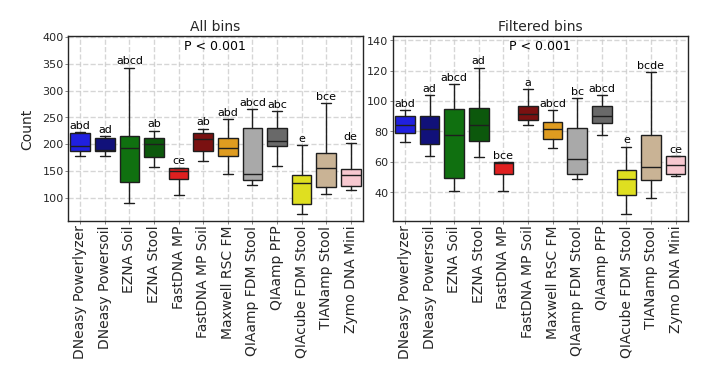

In [36]:
metrics = ['All bins', 'Filtered bins', 'Completeness', 'Contamination']
toplot = metrics[:2]
all_bins = pd.read_csv('Data/Bins/busco_summary.tsv', sep='\t', index_col=0)
good_bins = pd.read_csv('Data/Bins/busco_summary_good.tsv', sep='\t', index_col=0)
dfs = []

out_stats, out_figs = 'Results/MAG_stats', 'Figures/MAGs'

!mkdir -p {out_stats} {out_figs}

cols = len(toplot)
rows = 1
i = 0

fig, axes = plt.subplots(rows, cols, figsize=(4, 1.2), gridspec_kw={'hspace': .02, 'wspace': .1})

for met in metrics:
    bins = good_bins.copy() if met == 'Filtered bins' else all_bins.copy()
    bins = bins.loc[bins.Sample.isin(METAM.index)].copy()
    
    if met in toplot:
        data = pd.DataFrame(bins.groupby('Sample').size())
        data.columns = [met]
        data[['Kit', 'SID']] = METAM[['Kit', 'SID']]

        #stats
        summary = pd.DataFrame()
        kw, phoc = kw_wx_test(data, 'Kit', met, 'SID', pairwise=True)
        if kw[1] < 0.05:
            for ind in phoc.index:
                j = len(summary)
                summary.loc[j, ['Metric', 'Test']] = met, 'Dependent'
                summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
                summary.loc[j, ['Group1', 'Group2']] = phoc.loc[ind, ['Group1', 'Group2']]
                summary.loc[j, ['p', 'q']] = phoc.loc[ind, ['p', 'q']]
        else:
            j = len(summary)
            summary.loc[j, ['Metric', 'Test']] = met, 'Dependent'
            summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
            summary.loc[j, ['Group1', 'Group2', 'p', 'q']] = '-', '-', '-', '-'
        dfs.append(summary)
    
        # add P-general
        p_gen = round(summary.KW_WX.iloc[0], 3)
        
        ax, i = axes[i], i+1
        sns.boxplot(x='Kit', y=met, data=data, ax=ax, order=CDICT, linewidth=0.5, 
                    showfliers=False, palette=CDICT, )
            
    
        #aesthetics
        ax.tick_params(axis='both', labelsize=4, pad=.5, length=1, width=0.2 )
        ax.tick_params(axis='x', labelsize=5, rotation=90,)
        ax.yaxis.offsetText.set_fontsize(4)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.grid(lw=.5, ls='--', alpha=0.8) 
        ax.text(.5, 1.03, met, ha='center', fontsize=5, transform=ax.transAxes)
        if i == 1:
            ax.set_ylabel('Count', fontsize=5, labelpad=3)
            #ax.set_xlabel('DNA extraction kit', fontsize=6, labelpad=5, x=1.05)
    
        #plot p
        p = f'P = {p_gen}'
        if p_gen == 0:
            p = f'P < 0.001'
        c = 'black' if p_gen < .05 else 'dimgrey'
        ax.text(.5, 0.98, p, ha='center', va='top', fontsize=4.5, transform=ax.transAxes, c=c)
        
        #cld
        summary = summary.loc[summary.q != '-']
        if len(summary) == 0:
            continue
        cld = cld4py.assign_letters(summary, 'Group1', 'Group2', 'q', order='descending', 
                                    data=data, vals=met, group='Kit', param=False)
        #display(cld)
        cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='boxplot', pos='upper', 
                   vals=met, group='Kit', pad=1, c='black', fs=4, lim=15)
        
        
    else:
        data = bins.copy()
        data['Kit'] = data.Sample.map(dict(zip(METAM.index, METAM.Kit)))

        #stats
        summary = pd.DataFrame()
        kw, phoc = kw_test(data, 'Kit', met, pairwise=True)
        if kw[1] < 0.05:
            for ind in phoc.index:
                j = len(summary)
                summary.loc[j, ['Metric', 'Test']] = met, 'Independent'
                summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
                summary.loc[j, ['Group1', 'Group2']] = phoc.loc[ind, ['Group1', 'Group2']]
                summary.loc[j, ['p', 'q']] = phoc.loc[ind, ['p', 'q']]
        else:
            j = len(summary)
            summary.loc[j, ['Metric', 'Test']] = met, 'Inependent'
            summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
            summary.loc[j, ['Group1', 'Group2', 'p', 'q']] = '-', '-', '-', '-'
        dfs.append(summary)
    

summ = pd.concat(dfs)
summ.to_csv(f'{out_stats}/Bins_stats.tsv', sep='\t')
plt.savefig(f'{out_figs}/Bins.svg')
plt.savefig(f'{out_figs}/Bins.png')


## MAG stats

### Functions

In [2]:
out_stats, out_figs = 'Results/MAG_stats', 'Figures/MAGs'

!mkdir -p {out_stats} {out_figs}

### Filter tables

In [ ]:
#remove extra samples
!qiime feature-table filter-samples \
    --i-table Data/Bins/derep_mags_table.qza \
    --m-metadata-file MG-metadata.tsv \
    --o-filtered-table Data/Bins/derep_mags_table_filtered.qza

!qiime feature-table filter-samples \
    --i-table Data/Bins/mags_table_tpm.qza \
    --m-metadata-file MG-metadata.tsv \
    --o-filtered-table Data/Bins/mags_table_tpm_filtered.qza

### Export tables

In [ ]:
#export table
!qiime tools export \
    --input-path Data/Bins/derep_mags_table_filtered.qza \
    --output-path Data/Bins

#convert to txt
!biom convert -i Data/Bins/feature-table.biom -o Data/Bins/MAGs_dereplicated.tsv --to-tsv

#remove biom
!rm -f Data/Bins/feature-table.biom 

### Plot MAG stats

,Dereplicated MAGs,Kit,SID
K10_21,52,QIAamp FDM Stool,268/5
K10_23,85,QIAamp FDM Stool,258/2
K10_24,51,QIAamp FDM Stool,225/18
K10_26,89,QIAamp FDM Stool,958/76
K10_27,49,QIAamp FDM Stool,918/95
...,...,...,...
K9_28,82,DNeasy Powerlyzer,918/96
K9_29,69,DNeasy Powerlyzer,183/49
K9_30,83,DNeasy Powerlyzer,958/74
K9_41,82,DNeasy Powerlyzer,264/7


/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


,MAGs of good quality,Kit,SID
K10_21,17,QIAamp FDM Stool,268/5
K10_23,39,QIAamp FDM Stool,258/2
K10_24,18,QIAamp FDM Stool,225/18
K10_26,24,QIAamp FDM Stool,958/76
K10_27,20,QIAamp FDM Stool,918/95
...,...,...,...
K9_28,31,DNeasy Powerlyzer,918/96
K9_29,28,DNeasy Powerlyzer,183/49
K9_30,35,DNeasy Powerlyzer,958/74
K9_41,29,DNeasy Powerlyzer,264/7


/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/home/ty

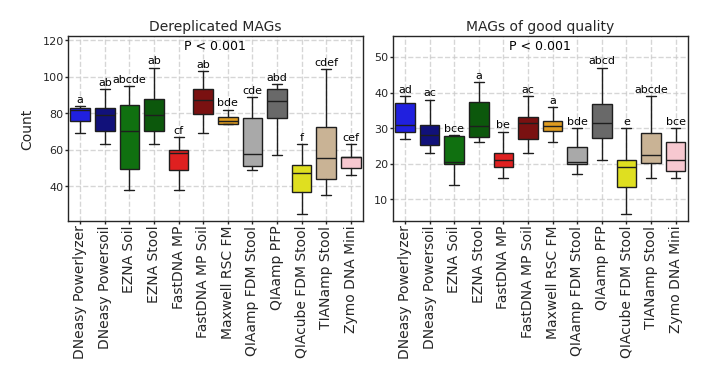

In [38]:
metrics = ['Dereplicated MAGs', 'MAGs of good quality']

#read tables
good_bins = pd.read_csv('Data/Bins/busco_summary_good.tsv', sep='\t', index_col=0)
taxa = pd.read_csv(f'Data/Bins/taxonomy.tsv', sep='\t', index_col=0)
table = pd.read_csv(f'Data/Bins/MAGs_dereplicated.tsv', sep='\t', index_col=0, skiprows=1).T

#count MAGs assigned to bacteria
table = table[[c for c in table.columns if 'd__Bacteria' in taxa.loc[c, 'Taxon']]]
count_bac = pd.DataFrame((table > 0).sum(axis=1))

#count MAGs of good quality
cm, ct = 90, 5 #completness, contamination
good = []
for c in table.columns:
    df = good_bins.loc[good_bins.MAG_UUID4 == c]
    m,t = df.loc[df.index[0], ['Completeness', 'Contamination']]
    if m >= cm and t < ct:
        good.append(c)
        
table = table[good]
count_good = pd.DataFrame((table > 0).sum(axis=1))

dfs = []

cols = len(metrics)
rows = 1
i = 0

fig, axes = plt.subplots(rows, cols, figsize=(4, 1.2), gridspec_kw={'hspace': .02, 'wspace': .1})

for i, met in enumerate(metrics):
    data = count_bac if i == 0 else count_good
    data.columns = [met]
    data[['Kit', 'SID']] = METAM[['Kit', 'SID']]

    display(data)

     #stats
    summary = pd.DataFrame()
    kw, phoc = kw_wx_test(data, 'Kit', met, 'SID', pairwise=True)
    if kw[1] < 0.05:
        for ind in phoc.index:
            j = len(summary)
            summary.loc[j, ['Metric', 'Test']] = met, 'Dependent'
            summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
            summary.loc[j, ['Group1', 'Group2']] = phoc.loc[ind, ['Group1', 'Group2']]
            summary.loc[j, ['p', 'q']] = phoc.loc[ind, ['p', 'q']]
    else:
        j = len(summary)
        summary.loc[j, ['Metric', 'Test']] = met, 'Dependent'
        summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
        summary.loc[j, ['Group1', 'Group2', 'p', 'q']] = '-', '-', '-', '-'
    dfs.append(summary)

    # add P-general
    p_gen = round(summary.KW_WX.iloc[0], 3)
    
    ax, i = axes[i], i+1
    sns.boxplot(x='Kit', y=met, data=data, ax=ax, order=CDICT, linewidth=0.5, 
                showfliers=False, palette=CDICT, )

    #aesthetics
    ax.tick_params(axis='both', labelsize=4, pad=.5, length=1, width=0.5 )
    ax.tick_params(axis='x', labelsize=5, rotation=90,)
    ax.yaxis.offsetText.set_fontsize(4.5)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(lw=.5, ls='--', alpha=0.8) 
    ax.text(.5, 1.03, met, ha='center', fontsize=5, transform=ax.transAxes)
    if i == 1:
        ax.set_ylabel('Count', fontsize=5, labelpad=3)
        #ax.set_xlabel('DNA extraction kit', fontsize=6, labelpad=5, x=1.05)

    #plot p
    p = f'P = {p_gen}'
    if p_gen == 0:
        p = f'P < 0.001'
    c = 'black' if p_gen < .05 else 'dimgrey'
    ax.text(.5, 0.98, p, ha='center', va='top', fontsize=4.5, transform=ax.transAxes, c=c)
    
    #cld
    summary = summary.loc[summary.q != '-']
    if len(summary) == 0:
        continue
    cld = cld4py.assign_letters(summary, 'Group1', 'Group2', 'q', order='descending', 
                                data=data, vals=met, group='Kit', param=False)
    #display(cld)
    cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='boxplot', pos='upper', 
               vals=met, group='Kit', pad=1, c='black', fs=4, lim=15)
    
summ = pd.concat(dfs)
summ.to_csv(f'{out_stats}/MAG_stats.tsv', sep='\t')
plt.savefig(f'{out_figs}/MAG_counts.svg')
plt.savefig(f'{out_figs}/MAG_counts.png')

### Good quality MAGs as heatmap (at least genus)

#### Filter tables

In [ ]:
cm, ct = 90, 5 #completness, contamination

#read tables
taxa = pd.read_csv(f'Data/Bins/taxonomy.tsv', sep='\t', index_col=0)
good_bins = pd.read_csv('Data/Bins/busco_summary_good.tsv', sep='\t', index_col=0)
good_bins = good_bins.loc[(good_bins.Completeness >= cm) & (good_bins.Contamination < ct)]
bacs = taxa.loc[taxa.Taxon.str.contains('d__Bacteria')]
bacs = bacs.loc[bacs.Taxon.str.contains('g__')]
good_bins = good_bins.loc[good_bins.MAG_UUID4.isin(bacs.index.tolist())]
good_bins = good_bins.set_index('MAG_UUID4')
good_bins.index.name = 'SampleID'
good_bins.to_csv(f'Data/Bins/high_qual_mags.tsv', sep='\t',)

#filter 
!qiime feature-table filter-features \
    --i-table Data/Bins/mags_table_tpm_filtered.qza \
    --m-metadata-file Data/Bins/high_qual_mags.tsv \
    --o-filtered-table Data/Bins/high_qual_mags_tpm.qza

#export table
!qiime tools export \
    --input-path Data/Bins/high_qual_mags_tpm.qza \
    --output-path Data/Bins

#convert to txt
!biom convert -i Data/Bins/feature-table.biom -o Data/Bins/high_qual_mags_tpm.tsv --to-tsv

#remove biom
!rm -f Data/Bins/feature-table.biom 

#### Plot heatmaps (tpm)

/tmp/ipykernel_30484/4183166468.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  tpm.index = tpm.index.str.replace(k, v)
/tmp/ipykernel_30484/4183166468.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  tpm.index = tpm.index.str.replace(k, v)
/tmp/ipykernel_30484/4183166468.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  tpm.index = tpm.index.str.replace(k, v)
/tmp/ipykernel_30484/4183166468.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  tpm.index = tpm.index.str.replace(k, v)
/tmp/ipykernel_30484/4183166468.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  tpm.index = tpm.index.str.replace(k, v)


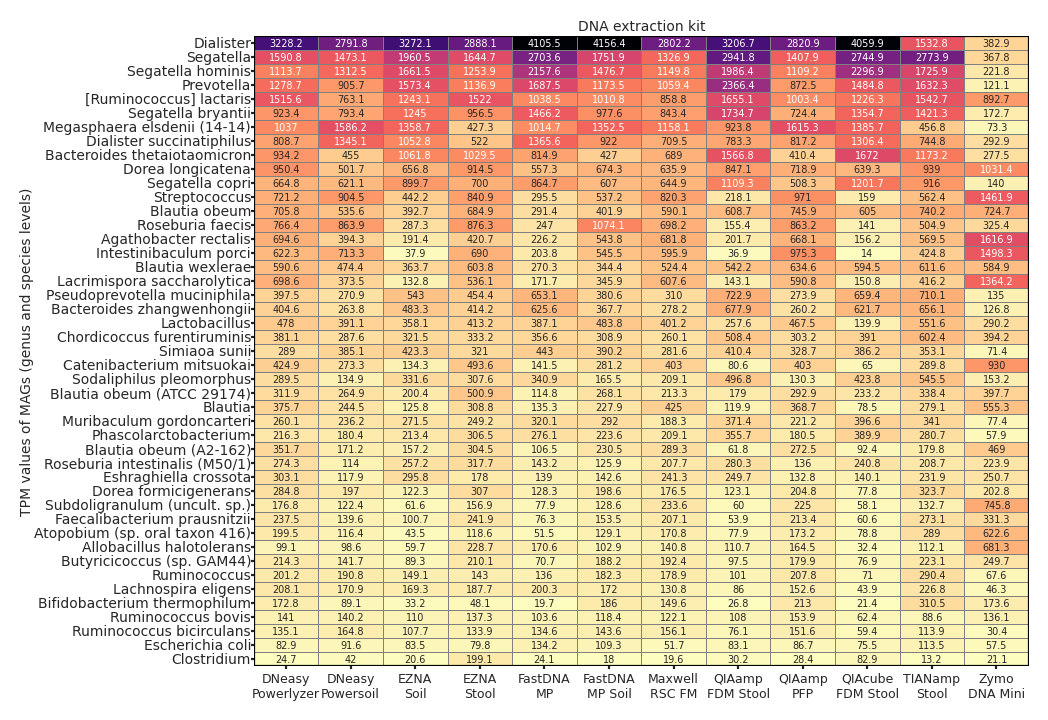

In [25]:
def aesthetics(ax, ylen, xlen):
    ax.axhline(y=0, color='k',linewidth=.8)
    ax.axhline(y=ylen, color='k',linewidth=.8)
    ax.axvline(x=0, color='k',linewidth=.8)
    ax.axvline(x=xlen, color='k',linewidth=.8)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(rotation=0, axis='both', labelsize=5, length=1, pad=0)
    ax.tick_params(rotation=0, axis='x', labelsize=4.5, length=1, pad=1)
    #ax.tick_params(axis='x', labelsize=5)


reps = {
    'Atopobium sp. oral taxon 416': 'Atopobium (sp. oral taxon 416)',
    'Butyricicoccus sp. GAM44': 'Butyricicoccus (sp. GAM44)',
    ' \(ex Wegman et al. 2014\)': '',
    'uncultured Subdoligranulum sp.': 'Subdoligranulum (uncult. sp.)',
    'Blautia obeum A2-162': 'Blautia obeum (A2-162)',
    'Blautia obeum ATCC 29174': 'Blautia obeum (ATCC 29174)',
    'ATCC 29176': '(ATCC 29176)',
    'Roseburia intestinalis M50/1': 'Roseburia intestinalis (M50/1)',
    'Megasphaera elsdenii 14-14': 'Megasphaera elsdenii (14-14)',
    ' \(ATCC 29176\)': '',
}

#read tables
taxa = pd.read_csv(f'Data/Bins/taxonomy.tsv', sep='\t', index_col=0)
tpm = pd.read_csv('Data/Bins/high_qual_mags_tpm.tsv', sep='\t', index_col=0, skiprows=1)
tpm['Taxon'] = taxa.Taxon
tpm = tpm.groupby('Taxon').mean()
tpm.index = tpm.index.str.split('__').str[-1]
for k, v in reps.items():
    tpm.index = tpm.index.str.replace(k, v)
tpm = tpm.T
tpm['Kit'] = METAM.Kit
tpm = tpm.groupby('Kit').mean().T
tpm = tpm.reindex(tpm.sum(axis=1).sort_values(ascending=False).index)
tpm.columns = [c.replace(' ', '\n').replace('\nFM', ' FM').replace('A\nMi', 'A Mi')\
               .replace('DM\nS', 'DM S').replace('P\nSo', 'P So') for c in tpm.columns]
tpm = tpm.round(1)

#set fig scaling
S = 11 #scale figure size
H = len(tpm)/S #height of figure
W = 5 #width of figure
step = 1/len(tpm) #height of 1 line

#set figure
cols = 1
rows = 1
fig, ax = plt.subplots(rows, cols, figsize=(W, H))

sns.heatmap(data=tpm, ax=ax, annot=True, cbar=False, cmap='magma_r',
            square=False, xticklabels=True, yticklabels=True, fmt='g',
            annot_kws={"size":3.5}, linewidths=.3, linecolor='grey')

#aesthetics
aesthetics(ax, len(tpm), len(CDICT))
ax.text(0.5, 1.01, 'DNA extraction kit', ha='center', fontsize=5, transform=ax.transAxes)
ax.set_ylabel('TPM values of MAGs (genus and species levels)', fontsize=5, labelpad=0)

plt.savefig(f'{out_figs}/MAGs_tpm.svg')
plt.savefig(f'{out_figs}/MAGs_tpm.png')

## FastQC

### Extract/pool data

In [ ]:
out_stats, out_figs = 'Results/FastQC_stats', 'Figures/FastQC'
!mkdir -p {out_stats} {out_figs}

qc_reps = pd.DataFrame()
BIG = '/home/ty/Big_data/LimBiom_Pilot/FastQC/'

for smpl in METAM.index:
    if not os.path.exists(f'{BIG}/postQC/{smpl}/{smpl}_1_val_1_fastqc.html'):
        continue
    pre = pd.read_html(f'{BIG}/preQC/{smpl}/{smpl}_1_fastqc.html')[0]
    qc_reps.loc[smpl, 'Raw depth'] = int(pre.loc[3, 'Value'])
    post = pd.read_html(f'{BIG}/postQC/{smpl}/{smpl}_1_val_1_fastqc.html')[0]
    qc_reps.loc[smpl, 'Depth'] = int(post.loc[3, 'Value'])
    #display(pre)
        
qc_reps['Retained (%)'] = qc_reps.Depth * 100 / qc_reps['Raw depth']
qc_reps.to_csv(f'{out_stats}/FastQC_data.tsv', sep='\t')
qc_reps        
        

### Plot FastQC

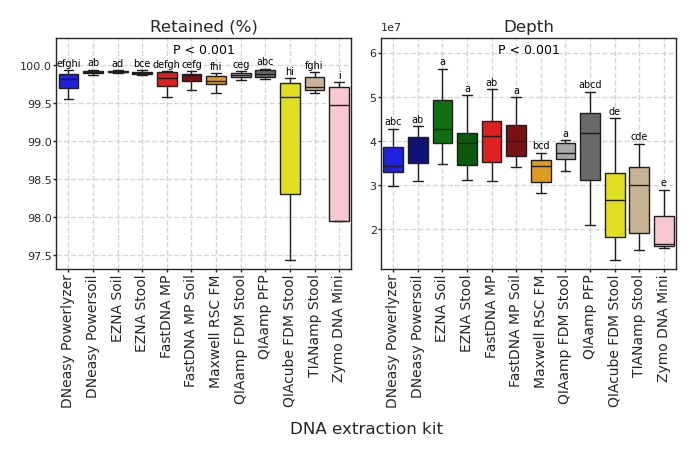

In [128]:
out_stats, out_figs = 'Results/FastQC_stats', 'Figures/FastQC'

metrics = ['Retained (%)', 'Depth']

#read tables
data = pd.read_csv(f'{out_stats}/FastQC_data.tsv', sep='\t', index_col=0)
data[['Kit', 'SID']] = METAM[['Kit', 'SID']]
dfs = []

cols = len(metrics)
rows = 1
i = 0

fig, axes = plt.subplots(rows, cols, figsize=(4, 1.5), gridspec_kw={'hspace': .02, 'wspace': .1})

for i, met in enumerate(metrics):

    #stats
    summary = pd.DataFrame()
    kw, phoc = kw_wx_test(data, 'Kit', met, 'SID', pairwise=True)
    if kw[1] < 0.05:
        for ind in phoc.index:
            j = len(summary)
            summary.loc[j, ['Metric', 'Test']] = met, 'Dependent'
            summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
            summary.loc[j, ['Group1', 'Group2']] = phoc.loc[ind, ['Group1', 'Group2']]
            summary.loc[j, ['p', 'q']] = phoc.loc[ind, ['p', 'q']]
    else:
        j = len(summary)
        summary.loc[j, ['Metric', 'Test']] = met, 'Dependent'
        summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
        summary.loc[j, ['Group1', 'Group2', 'p', 'q']] = '-', '-', '-', '-'
    dfs.append(summary)

    # add P-general
    p_gen = round(summary.KW_WX.iloc[0], 3)
    
    ax, i = axes[i], i+1
    sns.boxplot(x='Kit', y=met, data=data, ax=ax, order=CDICT, linewidth=0.5, 
                showfliers=False, palette=CDICT, )

    #aesthetics
    ax.tick_params(axis='both', labelsize=4, pad=.5, length=1, width=0.5 )
    ax.tick_params(axis='x', labelsize=5, rotation=90,)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(lw=.5, ls='--', alpha=0.8) 
    ax.text(.5, 1.03, met, ha='center', fontsize=6, transform=ax.transAxes)
    if i == 1:
        #ax.set_ylabel('Count', fontsize=6, labelpad=3)
        ax.set_xlabel('DNA extraction kit', fontsize=6, labelpad=5, x=1.05)

    #plot p
    p = f'P = {p_gen}'
    if p_gen == 0:
        p = f'P < 0.001'
    c = 'black' if p_gen < .05 else 'dimgrey'
    ax.text(.5, 0.98, p, ha='center', va='top', fontsize=4.5, transform=ax.transAxes, c=c)
    
    #cld
    summary = summary.loc[summary.q != '-']
    if len(summary) == 0:
        continue
    cld = cld4py.assign_letters(summary, 'Group1', 'Group2', 'q', order='descending', 
                                data=data, vals=met, group='Kit', param=False)
    #display(cld)
    cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='boxplot', pos='upper', 
               vals=met, group='Kit', pad=1, c='black', fs=3.5, lim=10)

summ = pd.concat(dfs)
summ.to_csv(f'{out_stats}/MAG_stats.tsv', sep='\t')
plt.savefig(f'{out_figs}/FastQC.svg')
plt.savefig(f'{out_figs}/FastQC.png')

# **Taxonomy**

## Import libraries and declare variables

In [15]:
colours = cc.glasbey_light
DOMS = ['Archaea', 'Bacteria', 'Eukaryota', 'Viruses', 'Others', 'Unassigned']

def bar_unzip(qza, lev):    
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ', '')
    inf = digest + f'/data/level-{lev}.csv'
    data = pd.read_csv(inf, sep=',', index_col=0, low_memory=False)
    !rm -rf $digest
    return data

out_stats, out_figs = 'Results/Taxabarplots_stats', 'Figures/Taxabarplots'

!mkdir -p {out_stats} {out_figs}

## Percentages of Domains

In [91]:
dfs = []

drep = {
    '_': ' ',
    ';': ' ',
}

for reg in POOL:
    meta = METAM.copy() if reg == 'MG' else META.copy()
    #data
    df = bar_unzip(f'Results/Taxabarplots/{reg}_taxabarplot.qzv', 1)
    df.columns = [c.replace('d__Unclassified', 'Unassigned') for c in df.columns]
    df.columns = ['d__Others' if 'd__containing' in c else c for c in df.columns ]
    df = df[[c for c in df.columns if 'd__' in c or c == "Unassigned"]]
    df.columns = [c.split('d__')[-1] for c in df.columns]
    for c in DOMS:
        if c not in df.columns:
            df[c] = 0
    df = df[DOMS]
    meta = meta.loc[df.index].copy()
    df = df.div(df.sum(axis=1), axis=0) * 100 #convert to % (rel ab)
    #df = df[df.columns.tolist()[-top:]]
    for k, v in drep.items():
        df.columns = [c.replace(k, v) for c in df.columns]
    df.columns = [c.strip(' ').split('  ')[-1] for c in df.columns]
    df = df.T.groupby(level=0).sum().T #sum duplicates
    df['Reg_Dada2'] = reg
    dfs.append(df)
    
doms_df = pd.concat(dfs)
doms_df.to_csv(f'Results/Taxabarplots/Relative_domains.tsv', sep='\t')

## Plot Regions pooled

/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/p

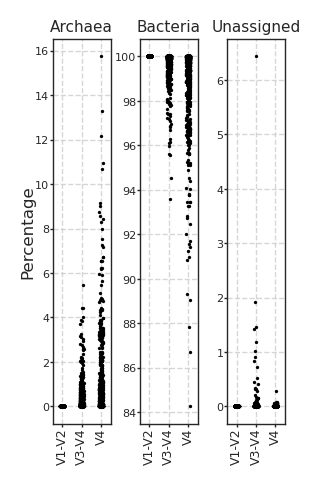

In [45]:
doms = ['Archaea', 'Bacteria', 'Unassigned']
cols = len(doms)
rows = 1
data = pd.read_csv(f'Results/Taxabarplots/Relative_domains.tsv', sep='\t', index_col=0)
data = data.loc[data['Reg_Dada2'].isin(POOL[1:])]
fig, axes = plt.subplots(rows, cols, figsize=(1.5, 2.5), gridspec_kw={'wspace': .5})

for i, dom in enumerate(doms):   
    ax = axes[i]
    sns.stripplot(x='Reg_Dada2', y=dom, data=data, ax=ax, size=1.2, c='black')
    ax.tick_params(axis='both', labelsize=4, pad=.2, length=1, width=0.5 )
    ax.tick_params(axis='x', labelsize=4.5, rotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(lw=.5, ls='--', alpha=0.8) 
    if i == 0:
        ax.set_ylabel('Percentage', fontsize=6, labelpad=0)
    ax.text(.5, 1.02, dom, ha='center', fontsize=5.5, transform=ax.transAxes)
    
plt.savefig(f'{out_figs}/Domains_regs.svg')
plt.savefig(f'{out_figs}/Domains_regs.png')

## Plot MG Kits

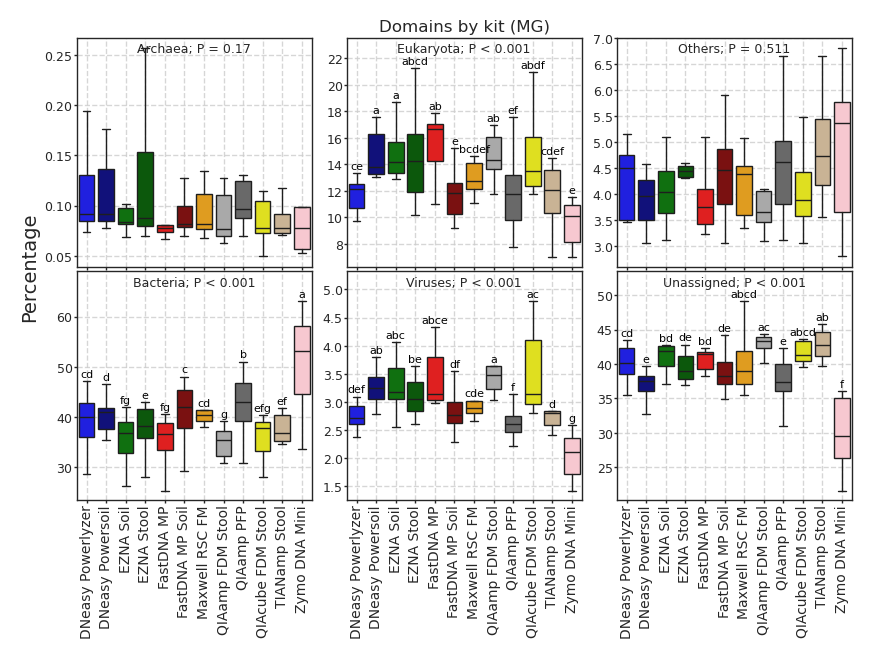

In [94]:
dfs = []
cols = 3
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(5, 3), gridspec_kw={'hspace': .02, 'wspace': .15})
axs = [[r, c] for c in range(cols) for r in range(rows)]
data = pd.read_csv(f'Results/Taxabarplots/Relative_domains.tsv', sep='\t', index_col=0)
data = data.loc[data['Reg_Dada2'] == 'MG']
data[['Kit', 'SID']] = METAM[['Kit', 'SID']]
for i, dom in enumerate(DOMS): 
    ax = axes[axs[i][0]][axs[i][1]]
    sns.boxplot(x='Kit', y=dom, data=data, ax=ax, order=CDICT, linewidth=0.5, 
                showfliers=False, palette=CDICT, )
    ax.tick_params(axis='both', labelsize=4.5, pad=.5, length=1, width=0.5 )
    ax.tick_params(axis='x', labelsize=5, rotation=90,)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(lw=.5, ls='--', alpha=0.8) 
    if i == 0:
        ax.set_ylabel('Percentage', fontsize=7, labelpad=2, y=0)
    if i == 2:
        ax.text(.5, 1.03, f'Domains by kit (MG)', ha='center', fontsize=6, transform=ax.transAxes)

    #stats
    summary = pd.DataFrame()
    kw, phoc = kw_wx_test(data, 'Kit', dom, 'SID', pairwise=True)
    if kw[1] < 0.05:
        for ind in phoc.index:
            j = len(summary)
            summary.loc[j, 'Metric'] = dom
            summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
            summary.loc[j, ['Group1', 'Group2']] = phoc.loc[ind, ['Group1', 'Group2']]
            summary.loc[j, ['p', 'q']] = phoc.loc[ind, ['p', 'q']]
    else:
        j = len(summary)
        summary.loc[j, 'Metric'] = dom
        summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
        summary.loc[j, ['Group1', 'Group2', 'p', 'q']] = '-', '-', '-', '-'
        
    # add P-general
    p_gen = round(summary.KW_WX.iloc[0], 3)
    p = f'P = {p_gen}'
    if p_gen == 0:
        p = f'P < 0.001'
    c = 'black' if p_gen < .05 else 'dimgrey'
    ax.text(.5, 0.98, f'{dom}; {p}', ha='center', va='top', fontsize=4.5, transform=ax.transAxes)

    #cld
    summary = summary.loc[summary.q != '-']
    if len(summary) == 0:
        continue
    cld = cld4py.assign_letters(summary, 'Group1', 'Group2', 'q', order='descending', 
                                data=data, vals=dom, group='Kit', param=False)
    #display(cld)
    cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='boxplot', pos='upper', 
               vals=dom, group='Kit', pad=1, c='black', fs=4, lim=10)
    dfs.append(summary)

summ = pd.concat(dfs)
summ.to_csv(f"{out_stats}/Domains_MG_dependent.tsv", sep='\t')
plt.savefig(f'{out_figs}/MG_Kits_domains.svg')
plt.savefig(f'{out_figs}/MG_Kits_domains.png')

### Descriptive stats

In [ ]:
dfs = []
data = pd.read_csv(f'Results/Taxabarplots/Relative_domains.tsv', sep='\t', index_col=0)
data = data.loc[data['Reg_Dada2'] == 'MG']
data[['Kit', 'SID']] = METAM[['Kit', 'SID']]
for i, dom in enumerate(DOMS): 
    for kit in CDICT:
        df = data.loc[(data['Kit'] == kit)]
        desc = pd.DataFrame(df[dom].describe()).T.reset_index(names='Factor')
        desc[['Domain', 'Kit']] = dom, kit
        dfs.append(desc)
    
df = pd.concat(dfs, ignore_index=True)
df['mean'] = df['mean'].apply(lambda x: round(x, 3))
df['median'] = df['50%'].apply(lambda x: round(x, 3))
df['IQR'] = df['75%'] - df['25%']
df['IQR'] = df['IQR'].apply(lambda x: round(x, 3))
df['std'] = df['std'].apply(lambda x: round(x, 3))
df = df[[c for c in df.columns if '%' not in c]]
df.to_csv(f'{out_stats}/MG_Kits_Domains_Descriptive.tsv', sep='\t', index=False)
display(df)

## Bacillota/Bacteroidota

### Extract

In [ ]:
dfs = []

for reg in POOL:
    #data
    lev = 3 if reg == 'MG' else 2
    df = bar_unzip(f'Results/Taxabarplots/{reg}_taxabarplot.qzv', lev)
    #df = df[[c for c in df.columns if 'p__' in c or c == "Unassigned"]]
    df.columns = [c.split('p__')[-1].split(';')[0] for c in df.columns]
    df['Bacillota/Bacteroidota ratio'] = df.Bacillota / df.Bacteroidota
    df = df[['Bacillota/Bacteroidota ratio']]
    df['Region'] = reg
    meta = METAM if reg == 'MG' else META
    df[['SID', 'Kit']] = meta[['SID', 'Kit']]
    dfs.append(df)
    
BB = pd.concat(dfs)
BB.to_csv(f'Results/Taxabarplots/BB_ratios.tsv', sep='\t')
BB

### Plot BB Ratios

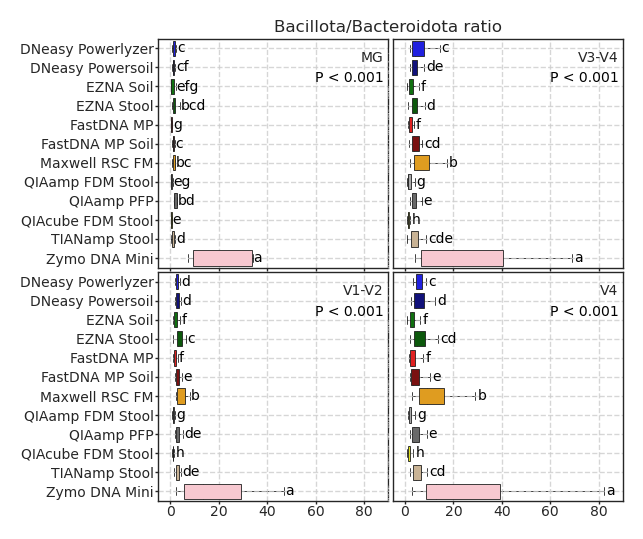

In [44]:
BB = pd.read_csv(f'Results/Taxabarplots/BB_ratios.tsv', sep='\t', index_col=0)
summary = pd.DataFrame()

#set figure
cols = 2
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(3, 3), 
                         gridspec_kw={'hspace': .02, 'wspace': .02})
axs, i = [[r, c] for c in range(cols) for r in range(rows)], 0
col = 'Bacillota/Bacteroidota ratio'

for i, reg in enumerate(POOL):
    data = BB.loc[BB.Region == reg].copy()
        
    # boxplots
    ax, i = axes[axs[i][0]][axs[i][1]], i+1
    sns.boxplot(y='Kit', x=col, data=data, ax=ax, zorder=-i,
            linewidth=0.3, palette=CDICT, showfliers=False, order=CDICT)
    if i == 1:
        ax.text(1, 1.03, col, ha='center', fontsize=6, transform=ax.transAxes, )
    ax.tick_params(axis='both', labelsize=5, pad=.5, length=1, width=0.5 )
    #ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(lw=.5, ls='--', alpha=0.8) 
    ax.text(.98, .9, reg, ha='right', fontsize=5, transform=ax.transAxes, )
    if i > 2:
        ax.tick_params(axis='y',labelsize=0, colors='white', rotation=90, pad=0, length=0)
    
    #stats
    kw, phoc = kw_wx_test(data, 'Kit', col, 'SID', pairwise=True)
    if kw[1] < 0.05:
        for ind in phoc.index:
            j = len(summary)
            summary.loc[j, ['Metric', 'Region']] = col, reg
            summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
            summary.loc[j, ['Group1', 'Group2']] = phoc.loc[ind, ['Group1', 'Group2']]
            summary.loc[j, ['p', 'q']] = phoc.loc[ind, ['p', 'q']]
    else:
        j = len(summary)
        summary.loc[j, ['Metric', 'Region']] = col, reg
        summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
        summary.loc[j, ['Group1', 'Group2', 'p', 'q']] = '-', '-', '-', '-'
        
    # add P-general
    summ = summary.loc[summary.Region == reg]
    p_gen = round(summ.KW_WX.iloc[0], 3)
    p = f'P = {p_gen}'
    if p_gen == 0:
        p = f'P < 0.001'
    c = 'black' if p_gen < .05 else 'dimgrey'
    ax.text(.98, .81, p, ha='right', fontsize=5, transform=ax.transAxes, c=c)

    #cld
    summ = summ.loc[summ.q != '-']
    cld = cld4py.assign_letters(summ, 'Group1', 'Group2', 'q', order='descending', 
                                data=data, vals=col, group='Kit', param=False)
    cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='y', plot='boxplot', pos='upper', 
               vals=col, group='Kit', pad=1, c='black', fs=5, lim=0)
    ax.set_xlim(-5, 90)
        
summary.to_csv(f'{out_stats}/KW_WX_BB_Ratios_dependent.tsv', sep='\t')
plt.savefig(f'{out_figs}/BB_Ratios.svg')
plt.savefig(f'{out_figs}/BB_Ratios.png')

## Plot Taxabarplots

### Pool data

In [ ]:
drep = {
    '_': ' ',
    ';': ' ',
    'Muribaculaceae g  Incertae Sedis': 'Muribaculaceae (Inc. Sedis)',
    'Rikenellaceae RC9 gut group': 'Rikenellaceae (RC9)',
    '[Eubacterium] coprostanoligenes group g  Incertae Sedis': 'Eubacterium (Inc. Sedis)',
    'Lachnospiraceae': 'Lachnospiraceae (uncl.)',
    'Prevotellaceae': 'Prevotellaceae (uncl.)',
    'Prevotellaceae (uncl.) g  Incertae Sedis': 'Prevotellaceae (Inc. Sedis)',
    'Peptostreptococcaceae': 'Peptostreptococcaceae (uncl.)',
    'Clostridia': 'Clostridia (uncl.)',
    'Clostridia (uncl.) UCG-014 f  Incertae Sedis g  Incertae Sedis': 'Clostridia (UCG-014)',
    'Bacillota': 'Bacillota (uncl.)',
    ' bacterium': ' (uncl.)',
    'uncultured (uncl.)': 'Uncult. bacterium',
    'Bacilli o  RF39 f  Incertae Sedis g  Incertae Sedis': 'Bacilli (RF39)',
    'Ruminococcaceae g  Incertae Sedis': 'Ruminococcaceae (Inc. Sedis)',
    'Selenomonadaceae g  Incertae Sedis': 'Selenomonadaceae (Inc. Sedis)'
}

top = 10
dfs = []

for reg in POOL:
    #data
    lev = 7 if reg == 'MG' else 6
    data = bar_unzip(f'Results/Taxabarplots/{reg}_taxabarplot.qzv', lev)
    data = data[[col for col in data.columns if 'd__' in col and '__Unclassified' not in col]]
    data = data[[col for col in data.columns if 'd__Bac' in col or 'd__Arc' in col]]
    
    for k, v in drep.items():
        data.columns = [c.replace(k, v) for c in data.columns]
    data.columns = [c.strip(' ').split('  ')[-1] for c in data.columns]
    data = data.T.groupby(level=0).sum().T #sum duplicates
    #display(data)
    data = data.div(data.sum(axis=1), axis=0) * 100 #convert to % (rel ab)
    data.loc['mean', :] = data.mean() #add a row with mean 
    data.sort_values(inplace=True, axis=1, by='mean', ascending=True) #sort features by mean of abundances
    data.drop(inplace=True, index='mean')
    data = data[data.columns.tolist()[-top:]]
    dfs.append(data.copy())

df = pd.concat(dfs)
df = df.fillna(0)
METAM['Region'] = 'MG'
meta = pd.concat([META, METAM]).copy()
meta = meta.loc[df.index]
meta = meta.loc[meta.SID != 'TrueFecal Control']
df = df.loc[meta.index].copy()
df.loc['mean', :] = df.mean() #add a row with mean 
df.sort_values(inplace=True, axis=1, by='mean', ascending=True) #sort features by mean of abundances
df.drop(inplace=True, index='mean')
df[['Kit', 'Region']] = meta[['Kit', 'Region']]
df = df.groupby(by=['Kit', 'Region']).mean()
display(df)
df.to_csv(f'Results/Taxabarplots/Genera_no_TrueFecal.tsv', sep='\t')

### Plot Kits by Region

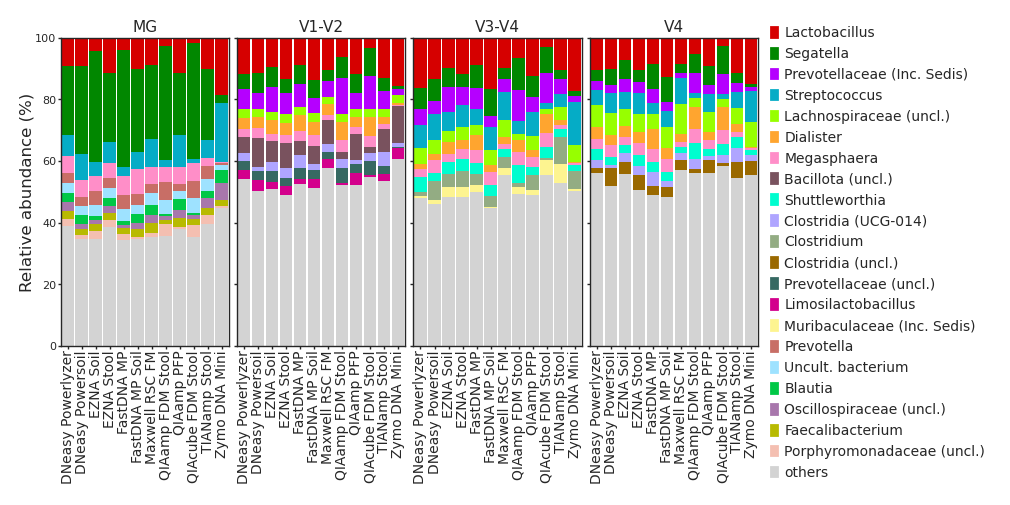

In [75]:
rows = 1
cols = len(POOL)
df = pd.read_csv(f'Results/Taxabarplots/Genera_no_TrueFecal.tsv', sep='\t', index_col=0)

#figure
fig, axes = plt.subplots(rows, cols, figsize=(4.5, 2), sharey='row', 
                         gridspec_kw={'wspace': .05})

#legend
cdict = dict(zip(df.columns.tolist()[::-1], colours))
legend = []

for i, reg in enumerate(POOL):
    ax = axes[i]
    data = df.loc[df.Region == reg].copy()
    data.drop('Region', inplace=True, axis=1)
    data = data.reindex(CDICT,)
    #display(data)

    bottom = [100 - data.loc[j,:].sum() for j in data.index] #starting points for stacked barplot
    ax.bar(x=data.index, height=bottom, color='lightgrey', width=.9, linewidth=0)
    for col in data.columns: #iterate through all features
        c = cdict[col] #define color
        if col not in legend: 
            legend = [col] + legend #add color to legend
        ax.bar(x=data.index, height=data[col], bottom=bottom, color=c, label=col, width=.9, linewidth=0)
        bottom = [a + b for a, b in zip(bottom, data[col].tolist())] #update bottom
        
    #aesthetics
    ax.tick_params(axis='both', labelsize=4, pad=.5, length=1, width=0.5) #adjust ticks
    ax.tick_params(axis='x', labelsize=5, labelrotation=90) #adjust ticks
    #ax.set_xticks([])
    ax.set_ylim(0, 100) #set limit for y axis
    ax.set_xlim(-.5, len(data.index) - .5) #set limit for x axis
    ax.set_ylabel('', fontsize=6, labelpad=0)
    if i == 0:
        ax.set_ylabel('Relative abundance (%)', fontsize=6, labelpad=0)
    ax.text(.5, 1.02, reg, ha='center', fontsize=5.5, transform=ax.transAxes)

#legend
labels = [l for l in df.columns[::-1] if l in legend] + ['others']                     
handles = [mpatches.Patch(color='lightgrey', label=l) if l == 'others' \
          else mpatches.Patch(color=cdict[l], label=l) for l in labels]

leg = ax.legend(handles, labels ,loc=2, bbox_to_anchor=(1, 1.08), fontsize=5, 
                frameon=False, handletextpad=0.5, handlelength=0.5, 
                bbox_transform=ax.transAxes, )  
leg._legend_box.align = "left"

plt.savefig(f'{out_figs}/Taxabarplot_Regions.svg')
plt.savefig(f'{out_figs}/Taxabarplot_Regions.png')

### Plot Regions by Kit

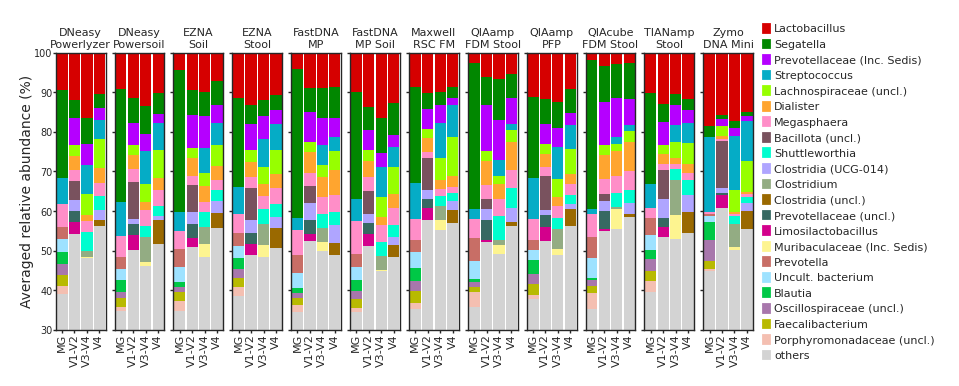

In [55]:
top = 25
rows = 1
cols = len(CDICT)
df = pd.read_csv(f'Results/Taxabarplots/Genera_no_TrueFecal.tsv', sep='\t', index_col=1)

#figure
fig, axes = plt.subplots(rows, cols, figsize=(4.5, 1.8), sharey='row', gridspec_kw={'wspace': .18})

#legend
cdict = dict(zip(df.columns.tolist()[::-1], colours))
legend = []

for i, kit in enumerate(CDICT):
    ax = axes[i]
    data = df.loc[df.Kit == kit].copy()
    data.drop('Kit', inplace=True, axis=1)
    data = data.reindex(POOL,)

    bottom = [100 - data.loc[j,:].sum() for j in data.index] #starting points for stacked barplot
    ax.bar(x=data.index, height=bottom, color='lightgrey', width=.9, linewidth=0)
    for col in data.columns: #iterate through all features
        c = cdict[col] #define color
        if col not in legend: 
            legend = [col] + legend #add color to legend
        ax.bar(x=data.index, height=data[col], bottom=bottom, color=c, label=col, width=.9, linewidth=0)
        bottom = [a + b for a, b in zip(bottom, data[col].tolist())] #update bottom
        
    #aesthetics
    ax.tick_params(axis='both', labelsize=3.5, pad=.2, length=1, width=0.5) #adjust ticks
    ax.tick_params(axis='x', labelsize=4, labelrotation=90) #adjust ticks
    #ax.set_xticks([])
    ax.set_ylim(30, 100) #set limit for y axis
    ax.set_xlim(-.5, len(data.index) - .5) #set limit for x axis
    ax.set_ylabel('', fontsize=6, labelpad=0)
    if i == 0:
        ax.set_ylabel('Averaged relative abundance (%)', fontsize=5, labelpad=0)
    ax.text(.5, 1.02, kit.replace(' ', '\n').replace('\nFM', ' FM').replace('A\nMi', 'A Mi').replace('DM\nS', 'DM S')\
            .replace('P\nSo', 'P So'), ha='center', fontsize=4, transform=ax.transAxes,)

#legend
labels = [l for l in df.columns[::-1] if l in legend] + ['others']                     
handles = [mpatches.Patch(color='lightgrey', label=l) if l == 'others' \
          else mpatches.Patch(color=cdict[l], label=l) for l in labels]

leg = ax.legend(handles, labels ,loc=2, bbox_to_anchor=(1, 1.14), fontsize=4, 
                frameon=False, handletextpad=0.5, handlelength=0.5, 
                bbox_transform=ax.transAxes,) 
leg._legend_box.align = "left"

plt.savefig(f'{out_figs}/Taxabarplot_Kits.svg')
plt.savefig(f'{out_figs}/Taxabarplot_Kits.png')

### Plot MG Species

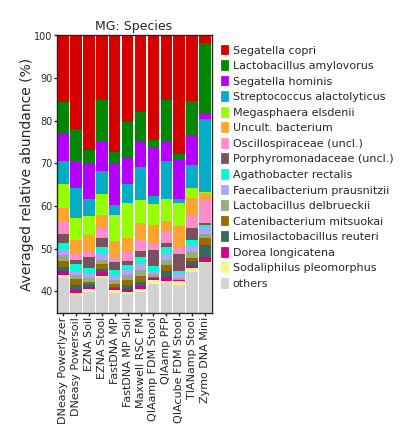

In [19]:
drep = {
    '_': ' ',
    ';': ' ',
    's (e': 's\n(e',
    ' bacterium': ' (uncl.)',
    'uncultured (uncl.)': 'Uncult. bacterium',
}

top = 15

data = bar_unzip(f'Results/Taxabarplots/MG_taxabarplot.qzv', 8)
data = data[[col for col in data.columns if 'd__' in col and '__Unclassified' not in col]]
data = data[[col for col in data.columns if 'd__Bac' in col or 'd__Arc' in col]]
for k, v in drep.items():
    data.columns = [c.replace(k, v) for c in data.columns]
data.columns = [c.strip(' ').split('  ')[-1] for c in data.columns]
data = data.T.groupby(level=0).sum().T #sum duplicates
data = data.div(data.sum(axis=1), axis=0) * 100 #convert to % (rel ab)
data.loc['mean', :] = data.mean() #add a row with mean 
data.sort_values(inplace=True, axis=1, by='mean', ascending=True) #sort features by mean of abundances
data.drop(inplace=True, index='mean')
data = data[data.columns.tolist()[-top:]]
meta = METAM.copy()
meta = meta.loc[data.index]
meta = meta.loc[meta.SID != 'TrueFecal Control']
df = data.loc[meta.index].copy()
df[['Kit']] = meta[['Kit']]
df = df.groupby(by='Kit').mean()
df.to_csv(f'Results/Taxabarplots/MG_Species_no_TrueFecal.tsv', sep='\t')
df.columns = [c for c in df.columns]

rows = 1
cols = 1

#figure
fig, ax = plt.subplots(rows, cols, figsize=(1, 1.8))

#legend
cdict = dict(zip(df.columns.tolist()[::-1], colours))
legend = []

data = df.copy()
data = data.reindex(CDICT,)

bottom = [100 - data.loc[j,:].sum() for j in data.index] #starting points for stacked barplot
ax.bar(x=data.index, height=bottom, color='lightgrey', width=.9, linewidth=0)
for col in data.columns: #iterate through all features
    c = cdict[col] #define color
    if col not in legend: 
        legend = [col] + legend #add color to legend
    ax.bar(x=data.index, height=data[col], bottom=bottom, color=c, label=col, width=.9, linewidth=0)
    bottom = [a + b for a, b in zip(bottom, data[col].tolist())] #update bottom
    
#aesthetics
ax.tick_params(axis='both', labelsize=3.5, pad=.5, length=1, width=0.5) #adjust ticks
ax.tick_params(axis='x', labelsize=4, labelrotation=90) #adjust ticks
#ax.set_xticks([])
ax.set_ylim(35, 100) #set limit for y axis
ax.set_xlim(-.5, len(data.index) - .5) #set limit for x axis
ax.set_ylabel('', fontsize=5, labelpad=0)
ax.set_ylabel('Averaged relative abundance (%)', fontsize=5, labelpad=0)
ax.text(.5, 1.02, 'MG: Species', ha='center', fontsize=4.5, transform=ax.transAxes)

#legend
labels = [l for l in df.columns[::-1] if l in legend] + ['others']                     
handles = [mpatches.Patch(color='lightgrey', label=l) if l == 'others' \
          else mpatches.Patch(color=cdict[l], label=l) for l in labels]
leg = ax.legend(handles, labels ,loc=2, bbox_to_anchor=(1, 1), fontsize=4, 
                frameon=False, handletextpad=0.5, handlelength=0.5, bbox_transform=ax.transAxes)  
leg._legend_box.align = "left"

plt.savefig(f'{out_figs}/Taxabarplot_MG_Species.svg')
plt.savefig(f'{out_figs}/Taxabarplot_MG_Species.png')

# **Alpha diversity**

### Import libraries, declare common variables

In [2]:
out_stats, out_figs = 'Results/Alpha_stats', 'Figures/Alpha'

!mkdir -p {out_stats} {out_figs}

### Plot by Region

MG 116
V1-V2 606
V3-V4 605
V4 607
MG 116
V1-V2 606
V3-V4 605
V4 607


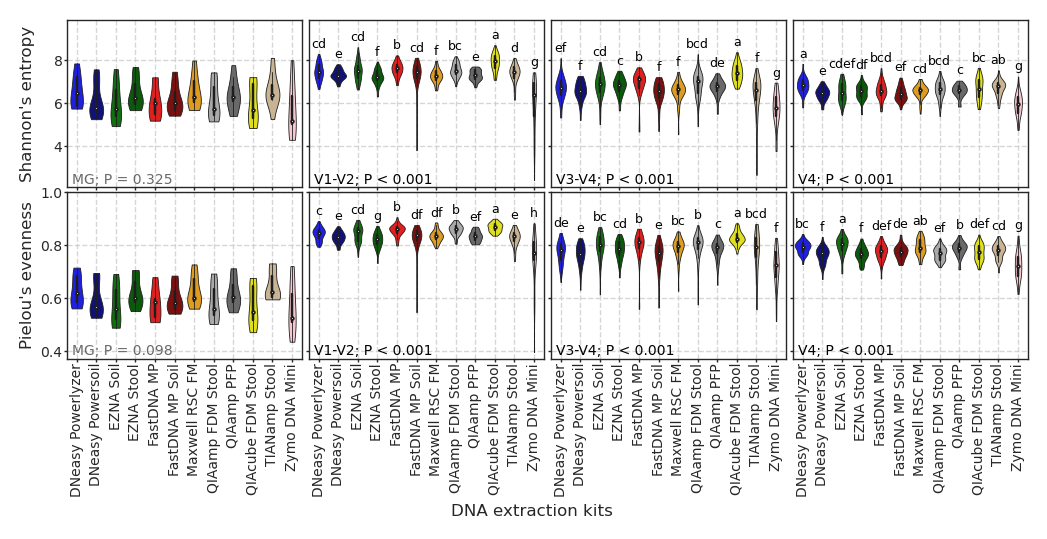

In [34]:
#By Region
summary = pd.DataFrame()
alphas = ['shannon', 'pielou_e']
metrics = pd.read_csv(f"{COREM}/alpha.tsv", sep='\t', index_col='SampleID')
metrics.loc

#set figure
rows = len(alphas)
cols = len(POOL)

fig, axes = plt.subplots(rows, cols, figsize=(6.2, 2.2), sharey='row',
                             gridspec_kw={'hspace': .03, 'wspace': .03})
axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0

for alpha in alphas:
    for reg in POOL:
        data = metrics[(metrics[alpha].notna()) & (metrics.Region == reg)].copy()
        print(reg, len(data))
        
        #violinplots
        ax, i = axes[axs[i][0]][axs[i][1]], i+1
        sns.violinplot(x='Kit', y=alpha, data=data, ax=ax, linewidth=0.3, cut=0,
                      order=CDICT, palette=CDICT)
        
        ax.tick_params(axis='both', labelsize=5, pad=.5, length=1, width=0.5 )
        ax.tick_params(axis='x', rotation=90)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.grid(lw=.5, ls='--', alpha=0.8) 
        if reg == POOL[0]:
            ax.set_ylabel(ALPHAS[alpha], fontsize=6, labelpad=2)
            #ax.text(1, 1.02, 'DNA extraction kits', ha='center', fontsize=5.5, transform=ax.transAxes)
        lims = ax.get_ylim()
        #if alpha != 'shannon':
        #    ax.set_ylim(min(lims)*.7, max(lims))

        #stats
        kw, phoc = kw_wx_test(data, 'Kit', alpha, 'SID', pairwise=True)
        if kw[1] < 0.05:
            for ind in phoc.index:
                j = len(summary)
                summary.loc[j, ['Metric', 'Region']] = alpha, reg
                summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
                summary.loc[j, ['Group1', 'Group2']] = phoc.loc[ind, ['Group1', 'Group2']]
                summary.loc[j, ['p', 'q']] = phoc.loc[ind, ['p', 'q']]
        else:
            j = len(summary)
            summary.loc[j, ['Metric', 'Region']] = alpha, reg
            summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
            summary.loc[j, ['Group1', 'Group2', 'p', 'q']] = '-', '-', '-', '-'

        # add P-general
        summ = summary.loc[(summary.Metric == alpha) & (summary.Region == reg)]
        p_gen = round(summ.KW_WX.iloc[0], 3)
        p = f'P = {p_gen}'
        if p_gen == 0:
            p = f'P < 0.001'
        c = 'black' if p_gen < .05 else 'dimgrey'
        ax.text(.02, .02, f'{reg}; {p}', ha='left', fontsize=5, transform=ax.transAxes, c=c)

        #cld
        summ = summ.loc[summ.q != '-']
        if len(summ) == 0:
            continue
        cld = cld4py.assign_letters(summ, 'Group1', 'Group2', 'q', order='descending', 
                                    data=data, vals=alpha, group='Kit', param=False)
        cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='violinplot', pos='upper', 
                   vals=alpha, group='Kit', pad=1, c='black', fs=4.5, lim=4)
        
fig.align_labels()
fig.suptitle('DNA extraction kits', y=-.22, fontsize=6, x=0.5)
plt.savefig(f'{out_figs}/Alpha.svg')
plt.savefig(f'{out_figs}/Alpha.png')

summary.to_csv(f'{out_stats}/KW_WX_alpha_dependent.tsv', sep='\t')

# **Beta diversity**

### Import libraries, declare common variables

In [2]:
adonis_out = 'Results/Adonis'

#function to modify adonis-strata output
def process_res(path, mode):
    resdf = pd.read_csv(path, sep='\t',)
    resdf[['Formula', 'Mode']] = [formula, mode]
    return resdf.loc[[i for i in resdf.index if i not in ['Residuals', 'Total']]]

#function to run adonis with strata
def run_adonis_strata(qza, meta, formula, strata=None, perms=999, t=4, pairwise=False):
    out = 'temp'
    
    !mkdir -p $out
    
    matrix = get_matrix(qza)
    subs = [m for m in matrix.columns if m in meta.index]
    matrix = matrix.loc[subs, subs]
    md = meta.loc[matrix.columns].copy()
    matrix.to_csv(f'{out}/matrix.tsv', sep='\t')        
    md.to_csv(f'{out}/md.tsv', sep='\t')
    adonisR = '/home/*/Nextcloud*/TY_scripts/run_adonis.R'
    columns = ['Df', 'SumsOfSqs', 'MeanSqs', 'F.Model', 'R2', 'Pr(>F)',\
               'Formula', 'Mode', 'Group1', 'Group2', 'p', 'q']
    summary = pd.DataFrame(columns = columns)
    com = f'{adonisR} {out}/matrix.tsv {out}/md.tsv {formula} {perms} {t} {strata} {out}/res.tsv'
                
    a = !$com

    resdf = process_res(f'{out}/res.tsv', 'General')
    summary = (summary.copy() if resdf.empty else resdf.copy() if summary.empty else pd.concat([summary, resdf]))
    
    if pairwise:
        for ind in pairwise:
            if resdf.loc[ind, 'Pr(>F)'] > .05: 
                continue
            subsum = pd.DataFrame(columns = columns)
            for pair in combinations(md[ind].unique(), 2):
                submd = md.loc[md[ind].isin(pair)]
                submx = matrix.loc[submd.index, submd.index].copy()
                submx.to_csv(f'{out}/mx-pairs.tsv', sep='\t')        
                submd.to_csv(f'{out}/md-pairs.tsv', sep='\t') 
                com = f'{adonisR} {out}/mx-pairs.tsv {out}/md-pairs.tsv {ind} {perms} {t} {strata} {out}/res-pairs.tsv'
                
                a = !$com
                
                subres = process_res(f'{out}/res-pairs.tsv', 'Pairwise')
                subres[['Group1', 'Group2']] = pair
                subsum = (subsum.copy() if subres.empty else subres.copy() if subsum.empty else pd.concat([subsum, subres]))
            subsum['p'] = subsum['Pr(>F)']
            subsum['Pr(>F)'] = resdf.loc[ind, 'Pr(>F)']
            subsum['q'] = multipletests(subsum['p'], method='fdr_bh')[1]
            subsum = subsum.loc[[ind], :].copy()
            summary = (summary.copy() if subsum.empty else subsum.copy() if summary.empty else pd.concat([summary, subsum]))

    !rm -r $out
    summary.index.name = 'Factor'
    return summary


# Unzipping qza pcoa
def parse_pcoa(qza): 
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ', '')
    inf = digest + '/data/ordination.txt'
    lines = open(inf, 'r').readlines()
    Eigvals = [float(i) for i in lines[1].rstrip().split('\t')]
    Proportion = [float(i) for i in lines[4].rstrip().split('\t')]
    pca_skipr = len(open(inf,'r').read().split('Site')[0].splitlines()) + 1
    pcoa = pd.read_csv(inf, index_col=0, skiprows=pca_skipr, skipfooter=4,\
                       header=None, sep='\t', engine='python')
    !rm -r $digest
    return  pcoa, Proportion


#function to unzip matrix
def get_matrix(qza):
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    inf = out + '/data/distance-matrix.tsv'
    matrix = pd.read_csv(inf, index_col=0, sep='\t')
    !rm -r $out
    return matrix

out_stats, out_figs = 'Results/Beta_stats', 'Figures/Beta'

!mkdir -p {out_stats} {out_figs}

### Adonis

In [ ]:
summs, clds = [], []

for reg in POOL + ['KO']:
    meta = METAM.copy() if reg in ['MG', 'KO'] else META.copy()
    qza = f'{COREM}/{reg}/distance_matrices/braycurtis.qza'
    formula = "'Kit + SID'"
    pairs = ['Kit']
    summ = run_adonis_strata(qza, meta, formula, pairwise=pairs)
    summ['Metric'] = 'Bray-Curtis'
    df = summ.loc[(summ.index=='Kit')&(summ.Mode == 'Pairwise')].copy()
    cld = cld4py.assign_letters(df, 'Group1', 'Group2', 'q')
    summ['Region'] = cld['Region'] = reg
    summs.append(summ)
    clds.append(cld)


summary = pd.concat(summs)
cld = pd.concat(clds)
cld.to_csv(f'{out_stats}/Kit-SID_adonis_CLD.tsv', sep='\t')
summary.to_csv(f'{out_stats}/Kit-SID_adonis.tsv', sep='\t')
display(summary, cld)

## Plot PCoA

/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


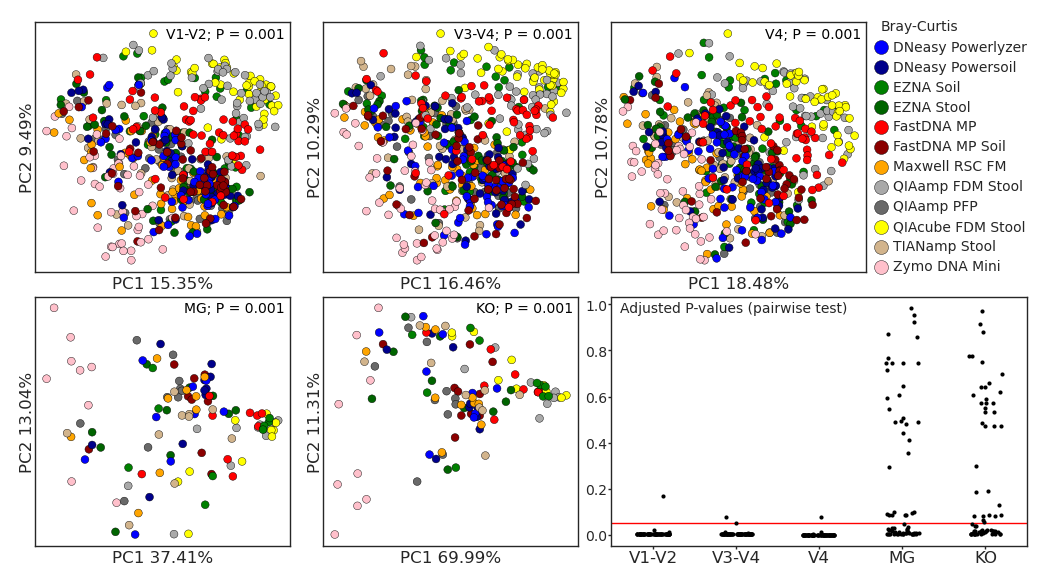

In [8]:
x, y = 1, 2 # axes to plot
show = ['Kit']
cols = 4
rows = 2

summary = pd.read_csv(f'{out_stats}/Kit-SID_adonis.tsv', sep='\t', index_col=0)
summary = summary.dropna(subset='q')
merged_list = ['V1-V2', 'V3-V4', 'V4', None, 'MG', 'KO']

fig, axes = plt.subplots(rows, cols, figsize=(6.4, 3.4), 
            gridspec_kw={'wspace': .15, 'hspace': .1, 'width_ratios': [1, 1, 1, .5]})
axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0

for reg in merged_list:
    meta = METAM.copy() if reg in ['MG', 'KO'] else META.copy()
    ax, i = axes[axs[i][0]][axs[i][1]], i+1
    if i == 4:
        # legend
        ax.axis('off')
        ax.set_ylim(0, 1)
        ax.set_xlim(0, 1)
        yax, xax = .98, -.15
        ystep, xstep = .08, 1
        fsize = 5
        ax.text(xax, yax -.012, 'Bray-Curtis', fontsize=fsize)

        for k,v in CDICT.items():
            yax -= ystep
            sns.scatterplot(x=[xax], y=[yax], ax=ax, s=25, clip_on=False, c=v, 
                            marker='o', linewidth=0.15, edgecolor='black')
            ax.text(xax + .1, yax -.015, k, fontsize=fsize)
    elif i < 7:
        ordin, Prop = parse_pcoa(f'{COREM}/{reg}/pcoas/braycurtis.qza')
        ordin[show] = meta[show]
        plot = sns.scatterplot(x=x, y=y, data=ordin, ax=ax, legend=False, hue='Kit', 
                               s=8, palette=CDICT, linewidth=0.15, edgecolor='black')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'PC{y:d} {Prop[y-1]*100:.2f}%', fontsize=6, labelpad=0)
        ax.set_xlabel(f'PC{x:d} {Prop[x-1]*100:.2f}%', fontsize=6, labelpad=1.5)
    if i == 3:
        ax.invert_xaxis()

    # add P-general
    if reg != None:
        summ = summary.loc[(summary.Metric == 'Bray-Curtis') & (summary.Region == reg)]
        p_gen = round(summ['Pr(>F)'].iloc[0], 3)
        p = f'P = {p_gen}'
        if p_gen == 0:
            p = f'P < 0.001'
        c = 'black' if p_gen < .05 else 'dimgrey'
        ax.text(.98, .98, f'{reg}; {p}', fontsize=5, ha='right', va='top', transform=ax.transAxes, c=c)

axes[1, 3].remove()
axes[1, 2].remove()
gs = axes[1, 2].get_gridspec()
axbig = fig.add_subplot(gs[1, 2:])
lst = [m for m in merged_list if m != None]

sns.stripplot(x='Region', y='q', data=summary, ax=axbig, size=1.5, 
              c='black', order=lst, jitter=.2)
axbig.axhline(y=0.05, color='red', linestyle='-', zorder=.8, lw=.5, alpha=1)
axbig.tick_params(axis='both', labelsize=5, length=1, pad=.5, width=0.5, )
axbig.tick_params(axis='x', labelsize=6, )
axbig.set_xlabel('')
axbig.set_ylabel('')
axbig.text(.02, .98, 'Adjusted P-values (pairwise test)', ha='left', va='top',
           fontsize=5, transform=axbig.transAxes)

plt.savefig(f'{out_figs}/PCoA_Kits.svg')
plt.savefig(f'{out_figs}/PCoA_Kits.png') 

# **Core Microbiome**

## Extract core features

### Genera

In [17]:
#function to get core features
def get_coref(qzv, prev='0.950'):    
    a = !unzip $qzv
    out = a[1].split('/')[0].replace('  inflating: ', '')
    data = pd.read_csv(f'{out}/data/core-features-{prev}.tsv', sep='\t', index_col=0)
    !rm -rf $out
    return data

out_figs = 'Figures/Core_features'

!mkdir -p {out_figs}

drep = {
    '_': ' ',
    ';': ' ',
    'Muribaculaceae g  Incertae Sedis': 'Muribaculaceae (Inc. Sedis)',
    'Rikenellaceae RC9 gut group': 'Rikenellaceae (RC9)',
    '[Eubacterium] coprostanoligenes group g  Incertae Sedis': 'Eubacterium (Inc. Sedis)',
    'Lachnospiraceae': 'Lachnospiraceae (uncl.)',
    'Prevotellaceae': 'Prevotellaceae (uncl.)',
    'Prevotellaceae (uncl.) g  Incertae Sedis': 'Prevotellaceae (Inc. Sedis)',
    'Peptostreptococcaceae': 'Peptostreptococcaceae (uncl.)',
    'Clostridia': 'Clostridia (uncl.)',
    'Clostridia (uncl.) UCG-014 f  Incertae Sedis g  Incertae Sedis': 'Clostridia (UCG-014)',
    'Bacillota': 'Bacillota (uncl.)',
    'Ruminococcaceae': 'Ruminococcaceae (uncl.)',
    'Bacilli o  RF39 f  Incertae Sedis g  Incertae Sedis': 'Bacilli (RF39)',
    'g  Erysipelotrichaceae UCG-006': 'Erysipelotrichaceae (UCG-006)',
    'Erysipelotrichaceae Erysipelotrichaceae (UCG-006)': 'Erysipelotrichaceae (UCG-006)',
    'Lachnospiraceae (uncl.) NK3A20 group': 'Lachnospiraceae (NK3A20)',
    'Prevotellaceae (uncl.) NK3B31 group': 'Prevotellaceae (NK3B31)',
    'Christensenellaceae R-7 group': 'Christensenellaceae (R-7)',
    'Bacteroidales f  Incertae Sedis g  Incertae Sedis': 'Bacteroidales (Inc. Sedis)',
    'Oscillospiraceae g  UCG-002': 'Oscillospiraceae (UCG-002)',
    'Selenomonadaceae g  Incertae Sedis': 'Selenomonadaceae (Inc. Sedis)',
    'Succinivibrionaceae UCG-001': 'Succinivibrionaceae (UCG-001)',
    '[Ruminococcus] gauvreauii group': 'Ruminococcus (gauvreauii)',
    'Oscillospiraceae': 'Oscillospiraceae (uncl.)',
    'Oscillospiraceae (uncl.) g  UCG-005': 'Oscillospiraceae (UCG-005)',
    'Ruminococcaceae (uncl.) g  Incertae Sedis': 'Ruminococcaceae (Inc. Sedis)',
    'Butyricicoccaceae': 'Butyricicoccaceae (uncl.)',
    ' bacterium': ' (uncl.)',
    'uncultured (uncl.)': 'Uncult. bacterium',
    '(uncl.) (uncl.)': '(uncl.)',
    'Clostridia (uncl.)les (uncl.)': 'Clostridiales (uncl.)',
    'uncultured Clostridia (uncl.)': 'Clostridia (uncl.)',
    'Clostridia (uncl.)ceae (uncl.) Marseille-Q4149': 'Clostridiaceae (Marseille-Q4149)',
    'NK4A214 group': 'Oscillospiraceae (NK4A214)',
    'Family XIII AD3011 group': 'Anaerovoracaceae(XIII AD3011)',
    'Oscillospirales f  UCG-010 g  Incertae Sedis': 'Oscillospirales (UCG-010, Inc. Sedis)',
    'Lachnospiraceae (uncl.) NK4A136 group': 'Lachnospiraceae (NK4A136)',
    'Erysipelotrichaceae UCG-009': 'Erysipelotrichaceae (UCG-009)',
}


#get core features
outdir = f'Results/Core-Genera'
prev = '0.950' #define prevalence in range "1.000" - "0.500" with step 50
cores = []
for reg in POOL:
    for kit in CDICT:
        kit = kit.replace(' ', '_')
        coref = f'{outdir}/{reg}-{kit}_core_gen.qzv'
        data = get_coref(coref, prev=prev)
        data[['Region', 'Kit']] = reg, kit.replace('_', ' ')
        cores.append(data)
core = pd.concat(cores)
core = core[[c for c in core.columns if not c.endswith('%')]]

core['Taxa'] = core.index.str.strip('__').str.strip(';').str.split(';__').str[0]
for k, v in drep.items():
    core['Taxa'] = core['Taxa'].apply(lambda x: x.replace(k, v))
core['Taxa'] = core['Taxa'].str.split('  ').str[-1]
core = core.loc[~core.Taxa.str.contains(' ')]
core.to_csv(f'{outdir}/Gore_genera_Reg_Kit_{prev}.tsv', sep='\t')

data = pd.DataFrame()
for reg in POOL:
    for kit in CDICT:
        j = len(data)
        data.loc[j, ['Region', 'Kit']] = reg, kit
        cor = core.loc[(core.Kit == kit)&(core.Region == reg)]
        for col in core.Taxa.unique():
            v = 0
            if col in cor.Taxa.tolist():
                v = 1
            data.loc[j, col] = v

data.to_csv(f'{outdir}/Gore_genera_Reg_Kit_{prev}_matrix.tsv', sep='\t')

### Species

In [32]:
#function to get core features
def get_coref(qzv, prev='0.950'):    
    a = !unzip $qzv
    out = a[1].split('/')[0].replace('  inflating: ', '')
    data = pd.read_csv(f'{out}/data/core-features-{prev}.tsv', sep='\t', index_col=0)
    !rm -rf $out
    return data

out_figs = 'Figures/Core_features'

drep = {
    '_': ' ',
    ';': ' ',
    ' bacterium': ' (uncl.)',
    'uncultured (uncl.)': 'Uncult. bacterium',
    '(uncl.) (uncl.)': '(uncl.)',
    'Clostridia (uncl.)les (uncl.)': 'Clostridiales (uncl.)',
    'uncultured Clostridia (uncl.)': 'Clostridia (uncl.)',
    'sp. co 0103': '(sp. co 0103)',
    '(uncl.) (uncl.)': '(uncl.)',
    'Clostridia (uncl.)les (uncl.)': 'Clostridiales (uncl.)',
    'uncultured Clostridia (uncl.)': 'Clostridia (uncl.)',
    'Clostridia (uncl.)ceae (uncl.) Marseille-Q4149': 'Clostridiaceae (Marseille-Q4149)',
    'NK4A214 group': 'Oscillospiraceae (NK4A214)',
    'Family XIII AD3011 group': 'Anaerovoracaceae(XIII AD3011)',
    'Oscillospirales f  UCG-010 g  Incertae Sedis': 'Oscillospirales (UCG-010, Inc. Sedis)',
    'Lachnospiraceae (uncl.) NK4A136 group': 'Lachnospiraceae (NK4A136)',
    'Erysipelotrichaceae UCG-009': 'Erysipelotrichaceae (UCG-009)',
}

#get core features
outdir = f'Results/Core-Genera'
prev = '0.950' #define prevalence in range "1.000" - "0.500" with step 50
cores = []
for reg in POOL:
    if reg != 'MG':
        continue
    for kit in CDICT:
        kit = kit.replace(' ', '_')
        coref = f'{outdir}/{reg}-{kit}_core_sps.qzv'
        data = get_coref(coref, prev=prev)
        data[['Region', 'Kit']] = reg, kit.replace('_', ' ')
        cores.append(data)
core = pd.concat(cores)
core = core[[c for c in core.columns if not c.endswith('%')]]

core['Taxa'] = core.index.str.strip('__').str.strip(';').str.split(';__').str[0]
for k, v in drep.items():
    core['Taxa'] = core['Taxa'].apply(lambda x: x.replace(k, v))
core['Taxa'] = core['Taxa'].str.split('  ').str[-1]
core = core.loc[~core.Taxa.str.contains('uncl.')]
core = core.loc[~core.Taxa.str.contains('Uncult. bacterium')]
core = core.loc[~core.Taxa.str.contains('GAM18')]
core = core.loc[~core.Taxa.str.contains('sp.')]
core.to_csv(f'{outdir}/Gore_species_MG_Kit_{prev}.tsv', sep='\t')

data = pd.DataFrame()
for reg in POOL:
    if reg != 'MG':
        continue
    for kit in CDICT:
        j = len(data)
        data.loc[j, ['Region', 'Kit']] = reg, kit
        cor = core.loc[(core.Kit == kit)&(core.Region == reg)]
        for col in core.Taxa.unique():
            v = 0
            if col in cor.Taxa.tolist():
                v = 1
            data.loc[j, col] = v

data.to_csv(f'{outdir}/Gore_species_MG_Kit_{prev}_matrix.tsv', sep='\t')

## Plot core matrix (genera)

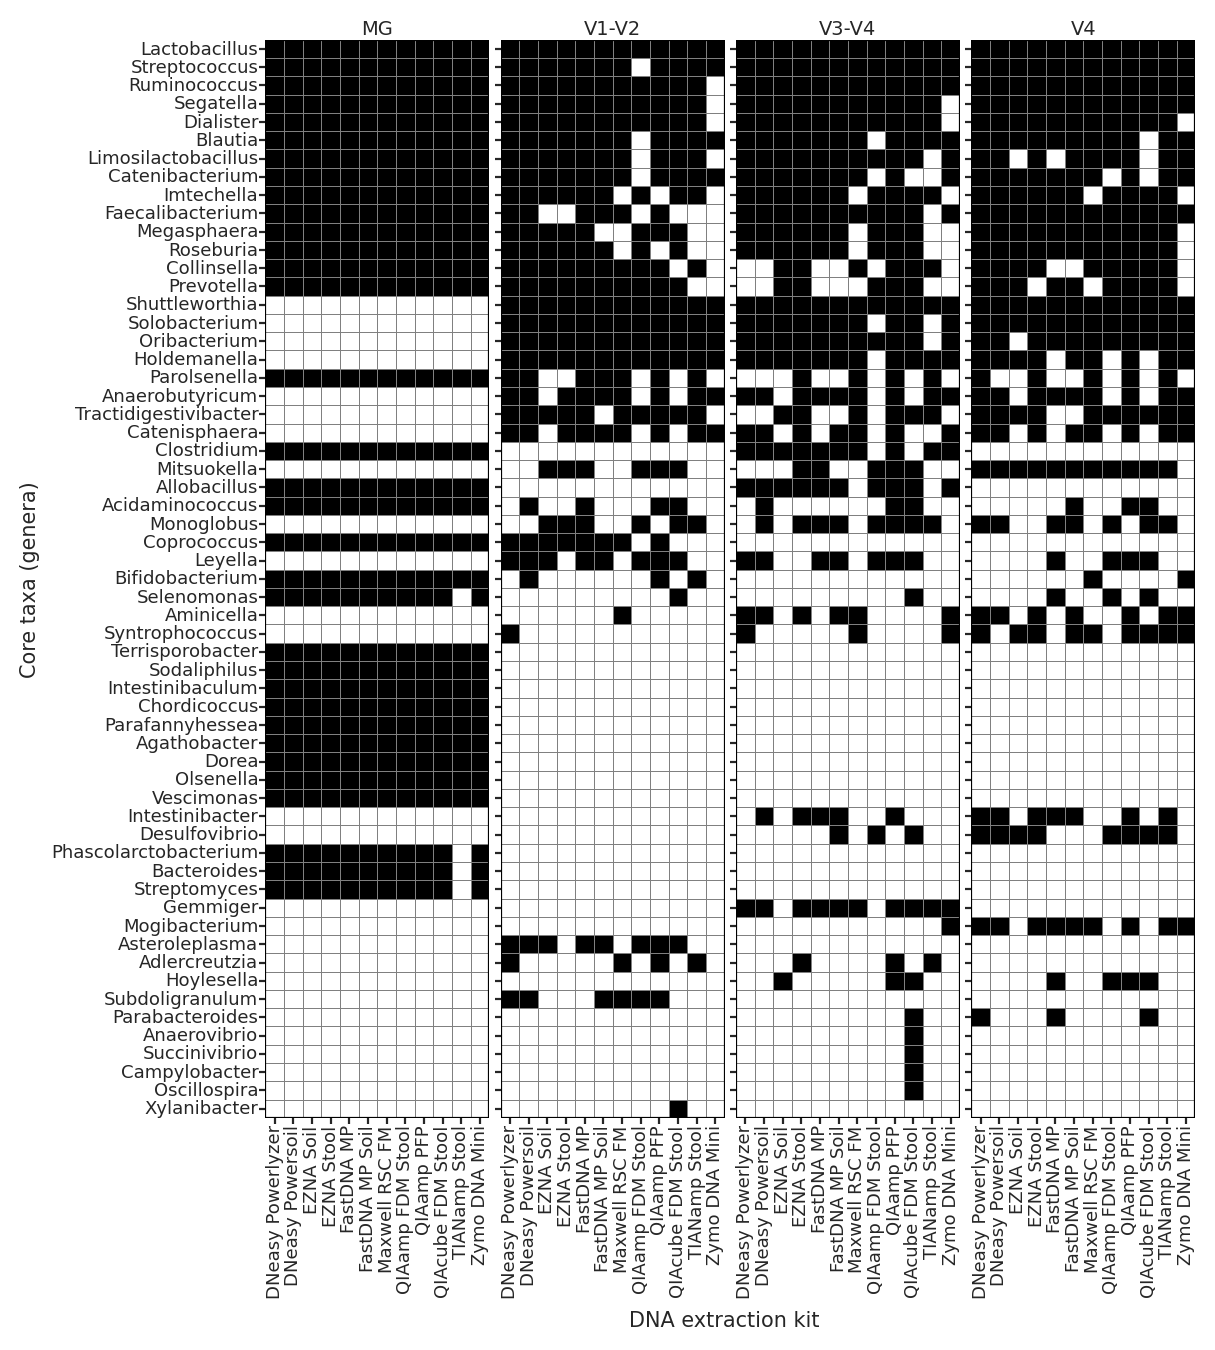

In [24]:
# plot core genera

out_figs = 'Figures/Core_features'

outdir = f'Results/Core-Genera'
prev = '0.950' #define prevalence in range "1.000" - "0.500" with step 50
data = pd.read_csv(f'{outdir}/Gore_genera_Reg_Kit_{prev}_matrix.tsv', 
                   sep='\t', index_col=0)

sort = data.copy()
sort.drop(['Kit', 'Region'], inplace=True, axis=1)
sort.loc['sum', :] = sort.sum() #add a row with mean
sort = sort.reindex(sorted(sort.columns), axis=1)
sort.sort_values(inplace=True, axis=1, by='sum', ascending=False) #sort features by mean of abundances
sort.drop(inplace=True, index='sum')
yorder = sort.columns.tolist()

#set figure
cols = len(POOL)
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(6, 7), sharey='row',
                         gridspec_kw={'wspace': .05}, )

for i, reg in enumerate(POOL):
    hdf = data.loc[data.Region == reg].copy()
    hdf.set_index('Kit', inplace=True)
    hdf.drop('Region', inplace=True, axis=1)
    hdf = hdf.T
    hdf = hdf.reindex(yorder)
    
    ax = axes[i]
    sns.heatmap(data=hdf, ax=ax, cbar=False, linewidths=.36, linecolor='grey', 
                xticklabels=True, yticklabels=True, cmap='binary')
    
    ax.axhline(y=0, color='k',linewidth=.8)
    ax.axhline(y=len(hdf), color='k',linewidth=.8)
    ax.axvline(x=0, color='k',linewidth=.8)
    ax.axvline(x=len(hdf.columns), color='k',linewidth=.8)
    ax.set_xlabel('')
    ax.set_ylabel('')
    if i == 0:
        ax.set_ylabel('Core taxa (genera)', fontsize=7.5)
    if i == 1:
        ax.set_xlabel('DNA extraction kit', fontsize=7.5, x=1)
    ax.tick_params(axis='both', labelsize=6.5, length=2, pad=.5)
    ax.tick_params(axis='x', rotation=90)
    ax.text(.5, 1.005, reg, ha='center', fontsize=7, transform=ax.transAxes)

plt.savefig(f'{out_figs}/Core_genera_samples.svg')
plt.savefig(f'{out_figs}/Core_genera_samples.png')

## Plot number of unique features

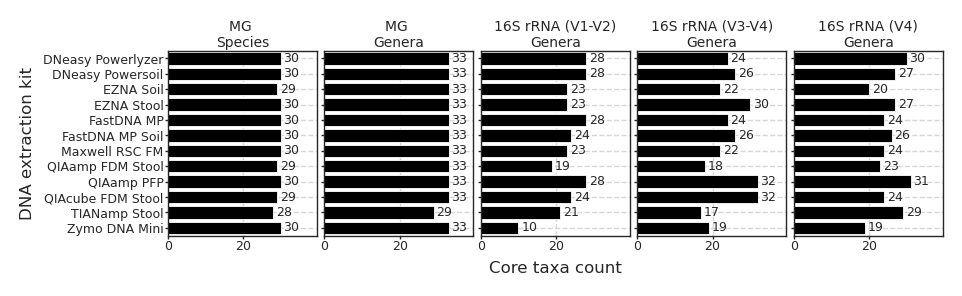

In [33]:
outdir = f'Results/Core-Genera'
prev = '0.950' #define prevalence in range "1.000" - "0.500" with step 50
gens = pd.read_csv(f'{outdir}/Gore_genera_Reg_Kit_{prev}.tsv', 
                   sep='\t', index_col=0)
spss = pd.read_csv(f'{outdir}/Gore_species_MG_Kit_{prev}.tsv', 
                   sep='\t', index_col=0)

POOLS = ['MG_SPS'] + POOL

count = pd.DataFrame()
for reg in POOLS:
    data = spss.copy() if reg == 'MG_SPS' else gens.copy()
    for kit in CDICT:
        df = data.loc[(data.Kit == kit)&(data.Region == reg.replace('_SPS', ''))]
        j = len(count)
        count.loc[j, ['Region', 'Kit']] = reg, kit
        count.loc[j, 'Core taxa count'] = len(df)

#set figure
rows = 1
cols = len(POOLS)
fig, axes = plt.subplots(rows, cols, figsize=(5, 1.2), sharey='row',
                         gridspec_kw={'wspace': .05})

for i, reg in enumerate(POOLS):
    data = count.loc[count.Region==reg]
    #barplots
    ax = axes[i]
    sns.barplot(x='Core taxa count', y='Kit', data=data, ax=ax, linewidth=0.3, 
                color='black', order=CDICT)
    
    ax.tick_params(axis='both', labelsize=4.5, pad=.5, length=1, width=0.5 )
    #ax.tick_params(axis='x', labelsize=5, rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('')
    if i == 0:
        ax.set_ylabel('DNA extraction kit', fontsize=6, labelpad=3)
    if i == 2:
        ax.set_xlabel('Core taxa count', fontsize=6, labelpad=3)
    ax.set_xlim(0, count['Core taxa count'].max()*1.2)
    ax.grid(lw=.5, ls='--', alpha=0.8)
    for i, container in enumerate(ax.containers):
        ax.bar_label(container, fmt='%.0f', fontsize=4.5, padding=1, )
    prefix = 'MG' if 'MG' in reg else '16S rRNA'
    suffix = 'Species' if 'SPS' in reg else 'Genera'
    target = '' if 'MG' in reg else f'({reg})'
    label = f"{prefix} {target}" +'\n'+ suffix
    ax.text(.5, 1.02, label, ha='center', fontsize=5, transform=ax.transAxes)

plt.savefig(f'{out_figs}/Core_genera_count.svg')
plt.savefig(f'{out_figs}/Core_genera_count.png')

# **ANCOM BC2 MG vs 16S**

## Functions

In [5]:
#get effect sizes, q-values and errors
def abc2_unzip(qza):
    trash = ['doctype','direction','style','fields','index','title','description','extra','(Intercept)']
    def jsonl(tab, trash=trash): 
        with open(f'{out}/data/{tab}.jsonl') as txt:
            return pd.read_json(txt, lines=True).drop(0).drop(trash, axis=1)
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    lfc, qval, se = jsonl('lfc'), jsonl('q'), jsonl('se')
    !rm -rf $out
    return lfc, qval, se
    

drep = {
    '_': ' ',
    ';': ' ',
    'Lachnospiraceae g  Incertae Sedis': 'Lachnospiraceae (Inc. Sedis)',
    'Muribaculaceae g  Incertae Sedis': 'Muribaculaceae (Inc. Sedis)',
    'Rikenellaceae RC9 gut group': 'Rikenellaceae (RC9)',
    '[Eubacterium] coprostanoligenes group g  Incertae Sedis': 'Eubacterium (Inc. Sedis)',
    'Lachnospiraceae': 'Lachnospiraceae (uncl.)',
    'Prevotellaceae': 'Prevotellaceae (uncl.)',
    'Prevotellaceae (uncl.) g  Incertae Sedis': 'Prevotellaceae (Inc. Sedis)',
    'Peptostreptococcaceae': 'Peptostreptococcaceae (uncl.)',
    'Clostridia': 'Clostridia (uncl.)',
    'Clostridia (uncl.) UCG-014 f  Incertae Sedis g  Incertae Sedis': 'Clostridia (UCG-014)',
    'Bacillota': 'Bacillota (uncl.)',
    'Ruminococcaceae': 'Ruminococcaceae (uncl.)',
    'Bacilli o  RF39 f  Incertae Sedis g  Incertae Sedis': 'Bacilli (RF39)',
    'g  Erysipelotrichaceae UCG-006': 'Erysipelotrichaceae (UCG-006)',
    'Erysipelotrichaceae Erysipelotrichaceae (UCG-006)': 'Erysipelotrichaceae (UCG-006)',
    'Lachnospiraceae (uncl.) NK3A20 group': 'Lachnospiraceae (NK3A20)',
    'Prevotellaceae (uncl.) NK3B31 group': 'Prevotellaceae (NK3B31)',
    'Christensenellaceae R-7 group': 'Christensenellaceae (R-7)',
    'Bacteroidales f  Incertae Sedis g  Incertae Sedis': 'Bacteroidales (Inc. Sedis)',
    'Oscillospiraceae g  UCG-002': 'Oscillospiraceae (UCG-002)',
    'Selenomonadaceae g  Incertae Sedis': 'Selenomonadaceae (Inc. Sedis)',
    'Succinivibrionaceae UCG-001': 'Succinivibrionaceae (UCG-001)',
    '[Ruminococcus] gauvreauii group': 'Ruminococcus (gauvreauii)',
    'Oscillospiraceae': 'Oscillospiraceae (uncl.)',
    'Oscillospiraceae (uncl.) g  UCG-005': 'Oscillospiraceae (UCG-005)',
    'Ruminococcaceae (uncl.) g  Incertae Sedis': 'Ruminococcaceae (Inc. Sedis)',
    'Butyricicoccaceae': 'Butyricicoccaceae (uncl.)',
    ' bacterium': ' (uncl.)',
    'uncultured (uncl.)': 'Uncult. bacterium',
    '(uncl.) (uncl.)': '(uncl.)',
    'Clostridia (uncl.)les (uncl.)': 'Clostridiales (uncl.)',
    'uncultured Clostridia (uncl.)': 'Clostridia (uncl.)',
    'Clostridia (uncl.)ceae (uncl.) Marseille-Q4149': 'Clostridiaceae (Marseille-Q4149)',
    'NK4A214 group': 'Oscillospiraceae (NK4A214)',
    'Family XIII AD3011 group': 'Anaerovoracaceae(XIII AD3011)',
    'Oscillospirales f  UCG-010 g  Incertae Sedis': 'Oscillospirales (UCG-010, Inc. Sedis)',
    'Lachnospiraceae (uncl.) NK4A136 group': 'Lachnospiraceae (NK4A136)',
    'Erysipelotrichaceae UCG-009': 'Erysipelotrichaceae (UCG-009)',
    'Erysipelotrichaceae UCG-002': 'Erysipelotrichaceae (UCG-002)',
    'Erysipelotrichaceae g  Incertae Sedis': 'Erysipelotrichaceae (Inc. Sedis)',
    'Atopobiaceae g  Incertae Sedis': 'Atopobiaceae (Inc. Sedis)',
    'Lachnospiraceae (uncl.) (Inc. Sedis)': 'Lachnospiraceae (Inc. Sedis)',
    'Prevotellaceae (uncl.) UCG-003': 'Prevotellaceae (UCG-003)',
    'Prevotellaceae (uncl.) UCG-001': 'Prevotellaceae (UCG-001)',
    'Coriobacteriales f  Incertae Sedis g  Incertae Sedis': 'Coriobacteriales (Inc. Sedis)',   
}

out, figs_out = 'Results/ANCOM-BC2_regs', 'Figures/Ancom-BC2'

!mkdir -p {out} {figs_out}

## Prepare data

### Export tables

In [ ]:
METAM['Region'] = 'MG'
MEGAMETA = pd.concat([META, METAM])
MEGAMETA.to_csv('megameta.tsv', sep='\t')
CORE = f'Results/Core-Genera'

for kit in CDICT:
    kit = kit.replace(' ', '_')

    for reg in POOL:
        
        #export table
        !qiime tools export \
            --input-path {CORE}/{reg}-{kit}_gen_table.qza \
            --output-path {out}
        
        #convert to txt
        !biom convert -i {out}/feature-table.biom -o {out}/{reg}-{kit}_gen_table.tsv --to-tsv
        !rm {out}/feature-table.biom

### Modify tables

In [9]:
for kit in CDICT:
    kit = kit.replace(' ', '_')
    dfs = []
    for reg in POOL:
        df = pd.read_csv(f'{out}/{reg}-{kit}_gen_table.tsv', sep='\t', index_col=0, skiprows=1)
        df['Taxa'] = df.index.str.strip('__').str.strip(';').str.split(';__').str[0]
        for k, v in drep.items():
            df['Taxa'] = df['Taxa'].apply(lambda x: x.replace(k, v))
        df['Taxa'] = df['Taxa'].str.split('  ').str[-1]
        #display(df.loc[df.Taxa == 'Incertae Sedis'])
        df = df.set_index('Taxa')
        df = df.groupby(df.index).sum()
        
        dfs.append(df)
    data = pd.concat(dfs, axis=1, )
    data = data.dropna()
    data.to_csv(f'{out}/{kit}_gen_table.tsv', sep='\t')

### Import tables

In [ ]:
for kit in CDICT:
    kit = kit.replace(' ', '_')

    !biom convert -i {out}/{kit}_gen_table.tsv -o {out}/{kit}_gen_table.biom --table-type="OTU table" --to-hdf5

    !qiime tools import \
        --input-path {out}/{kit}_gen_table.biom \
        --type 'FeatureTable[Frequency]' \
        --output-path {out}/{kit}_gen_table.qza

    !rm {out}/{kit}_gen_table.biom

## ABC2

### Run Ancom-BC2

In [ ]:
for kit in CDICT:
    kit = kit.replace(' ', '_')

    #Ancom-BC2
    !qiime composition ancombc2 \
        --i-table {out}/{kit}_gen_table.qza \
        --m-metadata-file megameta.tsv \
        --p-fixed-effects-formula Region \
        --p-reference-levels "Region::MG" \
        --p-num-processes 8 \
        --p-prevalence-cutoff 0.01 \
        --o-ancombc2-output {out}/{kit}-abc2.qza
    
    !qiime composition ancombc2-visualizer \
        --i-data {out}/{kit}-abc2.qza \
        --o-visualization {out}/{kit}-abc2.qzv  

### Merge outputs

In [ ]:
dfs = []

for kit in CDICT:
    KIT = kit.replace(' ', '_')
    lfc, qval, se = abc2_unzip(f'{out}/{KIT}-abc2.qza')
    lfc = lfc.melt(id_vars='taxon', value_name='LFC', var_name='Level')
    qval = qval.melt(id_vars='taxon', value_name='qval', var_name='Level')
    se = se.melt(id_vars='taxon', value_name='SE', var_name='Level')
    lfc['qval'] = qval['qval']
    lfc['SE'] = se['SE']
    lfc['Kit'] = kit
    lfc.Level = lfc.Level.str.split(':').str[-1]
    dfs.append(lfc)

summ = pd.concat(dfs, ignore_index=True)
summ = summ.loc[(summ['qval'] < .05) & (summ['LFC'].abs() >= 1)]
display(summ)
summ.to_csv(f'{out}/ABC2.tsv', sep='\t', index=False)

## Plot ABC2

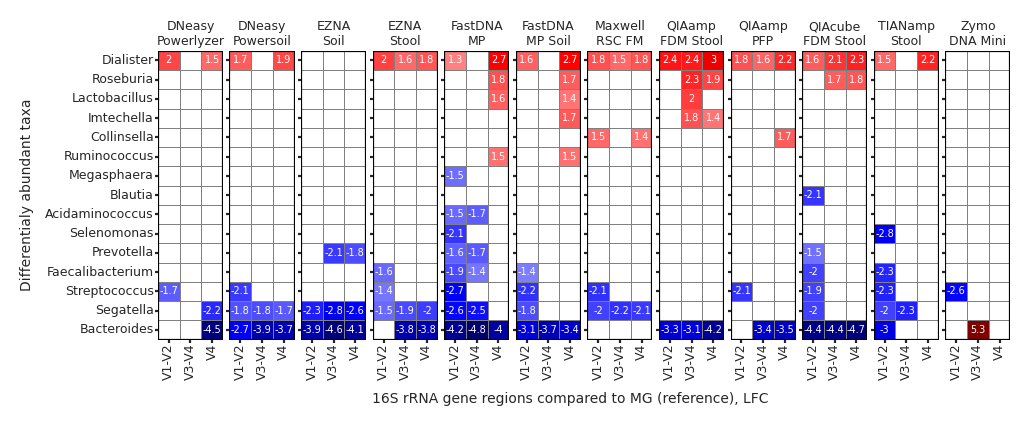

In [9]:
def aesthetics(ax, ylen, xlen):
    ax.axhline(y=0, color='k',linewidth=.8)
    ax.axhline(y=ylen, color='k',linewidth=.8)
    ax.axvline(x=0, color='k',linewidth=.8)
    ax.axvline(x=xlen, color='k',linewidth=.8)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(rotation=0, axis='both', labelsize=4.5, length=1, pad=.5)
    ax.tick_params(rotation=90, axis='x', labelsize=4.5,)

summ = pd.read_csv(f'{out}/ABC2.tsv', sep='\t')
summ.taxon = summ.taxon.str.replace('(uncl.) (UCG-002)', '(UCG-002)', regex=False)
summ.sort_values(by='LFC', ascending=False, inplace=True)
vmax, vmin = summ.LFC.max(), summ.LFC.min() #max and min values for cbar
grouped = pd.DataFrame(summ.groupby('taxon')['LFC'].sum())
grouped.sort_values(by='LFC', ascending=False, inplace=True)
yorder = grouped.index.unique().tolist()
#set fig scaling
S = 8 #scale figure size
H = len(yorder)/S #height of figure
W = (len(CDICT) - 1)/2 #width of figure
step = 1/len(yorder) #height of 1 line

#set figure
cols = len(CDICT)
rows = 1
fig, axes = plt.subplots(rows, cols, figsize=(W, H), sharey='row',
                         gridspec_kw={'wspace': .1})

for i, kit in enumerate(CDICT):
    data = summ.loc[summ.Kit == kit].set_index('taxon').copy()
    hdf = data.pivot(columns=['Level'], values='LFC')

    #fix columns
    for reg in MDICT:
        if reg not in hdf.columns:
            hdf[reg] = np.nan
    hdf = hdf[list(MDICT.keys())]

    #fix rows
    for ind in yorder:
        if ind not in hdf.index:
            hdf.loc[ind, :] = np.nan
    hdf = hdf.reindex(yorder)

    #plot
    ax = axes[i]
    sns.heatmap(data=hdf, ax=ax, annot=True, cbar=False, 
                square=False, center=0, cmap='seismic', xticklabels=True, yticklabels=True,
                annot_kws={"size":3.5}, linewidths=.3, linecolor='grey', vmax=vmax, vmin=vmin)
    
    #aesthetics
    aesthetics(ax, len(yorder), len(MDICT))
    ax.text(len(MDICT)/2, -.3, kit.replace(' ', '\n').replace('\nFM', ' FM').replace('A\nMi', 'A Mi')\
            .replace('DM\nS', 'DM S').replace('P\nSo', 'P So'), ha='center', fontsize=4.5, transform=ax.transData)
    if i == 0:
        ax.set_ylabel('Differentialy abundant taxa', fontsize=5)

fig.suptitle('16S rRNA gene regions compared to MG (reference), LFC', y=-.03, fontsize=5, x=0.5)
plt.savefig(f'{figs_out}/ABC2_regs-by-kit.svg')
plt.savefig(f'{figs_out}/ABC2_regs-by-kit.png')

# **ANCOM BC2 16S Regions / Kits**

## Functions

In [10]:
#get effect sizes, q-values and errors

#ATTENTION - P-values for readj. instead of q-values
def abc2_unzip(qza):
    trash = ['doctype','direction','style','fields','index','title','description','extra','(Intercept)']
    def jsonl(tab, trash=trash): 
        with open(f'{out}/data/{tab}.jsonl') as txt:
            return pd.read_json(txt, lines=True).drop(0).drop(trash, axis=1)
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    lfc, pval, se = jsonl('lfc'), jsonl('p'), jsonl('se')
    !rm -rf $out
    return lfc, pval, se
    

drep = {
    '_': ' ',
    ';': ' ',
    'Lachnospiraceae g  Incertae Sedis': 'Lachnospiraceae (Inc. Sedis)',
    'Muribaculaceae g  Incertae Sedis': 'Muribaculaceae (Inc. Sedis)',
    'Rikenellaceae RC9 gut group': 'Rikenellaceae (RC9)',
    '[Eubacterium] coprostanoligenes group g  Incertae Sedis': 'Eubacterium (Inc. Sedis)',
    'Lachnospiraceae': 'Lachnospiraceae (uncl.)',
    'Prevotellaceae': 'Prevotellaceae (uncl.)',
    'Prevotellaceae (uncl.) g  Incertae Sedis': 'Prevotellaceae (Inc. Sedis)',
    'Peptostreptococcaceae': 'Peptostreptococcaceae (uncl.)',
    'Clostridia': 'Clostridia (uncl.)',
    'Clostridia (uncl.) UCG-014 f  Incertae Sedis g  Incertae Sedis': 'Clostridia (UCG-014)',
    'Bacillota': 'Bacillota (uncl.)',
    'Ruminococcaceae': 'Ruminococcaceae (uncl.)',
    'Bacilli o  RF39 f  Incertae Sedis g  Incertae Sedis': 'Bacilli (RF39)',
    'g  Erysipelotrichaceae UCG-006': 'Erysipelotrichaceae (UCG-006)',
    'Erysipelotrichaceae Erysipelotrichaceae (UCG-006)': 'Erysipelotrichaceae (UCG-006)',
    'Lachnospiraceae (uncl.) NK3A20 group': 'Lachnospiraceae (NK3A20)',
    'Prevotellaceae (uncl.) NK3B31 group': 'Prevotellaceae (NK3B31)',
    'Christensenellaceae R-7 group': 'Christensenellaceae (R-7)',
    'Bacteroidales f  Incertae Sedis g  Incertae Sedis': 'Bacteroidales (Inc. Sedis)',
    'Oscillospiraceae g  UCG-002': 'Oscillospiraceae (UCG-002)',
    'Selenomonadaceae g  Incertae Sedis': 'Selenomonadaceae (Inc. Sedis)',
    'Succinivibrionaceae UCG-001': 'Succinivibrionaceae (UCG-001)',
    '[Ruminococcus] gauvreauii group': 'Ruminococcus (gauvreauii)',
    'Oscillospiraceae': 'Oscillospiraceae (uncl.)',
    'Oscillospiraceae (uncl.) g  UCG-005': 'Oscillospiraceae (UCG-005)',
    'Ruminococcaceae (uncl.) g  Incertae Sedis': 'Ruminococcaceae (Inc. Sedis)',
    'Butyricicoccaceae': 'Butyricicoccaceae (uncl.)',
    ' bacterium': ' (uncl.)',
    'uncultured (uncl.)': 'Uncult. bacterium',
    '(uncl.) (uncl.)': '(uncl.)',
    'Clostridia (uncl.)les (uncl.)': 'Clostridiales (uncl.)',
    'uncultured Clostridia (uncl.)': 'Clostridia (uncl.)',
    'Clostridia (uncl.)ceae (uncl.) Marseille-Q4149': 'Clostridiaceae (Marseille-Q4149)',
    'NK4A214 group': 'Oscillospiraceae (NK4A214)',
    'Family XIII AD3011 group': 'Anaerovoracaceae(XIII AD3011)',
    'Oscillospirales f  UCG-010 g  Incertae Sedis': 'Oscillospirales (UCG-010, Inc. Sedis)',
    'Lachnospiraceae (uncl.) NK4A136 group': 'Lachnospiraceae (NK4A136)',
    'Erysipelotrichaceae UCG-009': 'Erysipelotrichaceae (UCG-009)',
    'Erysipelotrichaceae UCG-002': 'Erysipelotrichaceae (UCG-002)',
    'Erysipelotrichaceae g  Incertae Sedis': 'Erysipelotrichaceae (Inc. Sedis)',
    'Atopobiaceae g  Incertae Sedis': 'Atopobiaceae (Inc. Sedis)',
    'Lachnospiraceae (uncl.) (Inc. Sedis)': 'Lachnospiraceae (Inc. Sedis)',
    'Prevotellaceae (uncl.) UCG-003': 'Prevotellaceae (UCG-003)',
    'Prevotellaceae (uncl.) UCG-001': 'Prevotellaceae (UCG-001)',
    'Coriobacteriales f  Incertae Sedis g  Incertae Sedis': 'Coriobacteriales (Inc. Sedis)',   
}

out, out_figs = 'Results/LFC', 'Figures/LFC'
abc2 = 'Results/ANCOM-BC2_regs'
subkits = ['QIAamp PFP', 'FastDNA MP Soil', 'EZNA Stool']

LFCdict = {
    '16S rRNA gene regions': [('V1-V2', 'V3-V4'), ('V1-V2', 'V4'), ('V3-V4', 'V4')],
    'DNA extraction kits': [('QIAamp PFP', 'FastDNA MP Soil'), 
                            ('QIAamp PFP', 'EZNA Stool'), ('FastDNA MP Soil', 'EZNA Stool')],
}

!mkdir -p {out} {out_figs}

## Prepare data

### Merge and filter tables

In [ ]:
for subtype, pairs in LFCdict.items():
    if subtype == list(LFCdict.keys())[0]:
        for kit in subkits:
            KIT = kit.replace(' ', '_')
            tabin = f"{abc2}/{KIT}_gen_table.qza"
            for p1, p2 in pairs:

                #filter tables
                retain = f"[Region] IN ('{p1}', '{p2}') AND [Kit]='{kit}'"
                tabex = f'{out}/{KIT}_{p1}_{p2}_table.qza'

                !qiime feature-table filter-samples \
                    --i-table $tabin \
                    --m-metadata-file metadata.tsv \
                    --p-where "$retain" \
                    --o-filtered-table $tabex
                
    else:
        #merge tables
        tables = " ".join([f"{abc2}/{k.replace(' ', '_')}_gen_table.qza" for k in subkits])
        
        !qiime feature-table merge \
            --i-tables {tables} \
            --o-merged-table {out}/subkits_table.qza
        
        for reg in MDICT:
            for p1, p2 in pairs:

                #filter tables
                retain = f"[Kit] IN ('{p1}', '{p2}') AND [Region]='{reg}'"
                tabex = f'{out}/{reg}_{p1}_{p2}_table.qza'.replace(' ', '_')

                !qiime feature-table filter-samples \
                    --i-table {out}/subkits_table.qza \
                    --m-metadata-file metadata.tsv \
                    --p-where "$retain" \
                    --o-filtered-table $tabex                

## ABC2

### Run Ancom-BC2

In [ ]:
def abc2_run(tabin, formula, ref, artifact):

    #Ancom-BC2
    !qiime composition ancombc2 \
        --i-table {tabin} \
        --m-metadata-file megameta.tsv \
        --p-fixed-effects-formula {formula} \
        --p-reference-levels {ref} \
        --p-num-processes 8 \
        --o-ancombc2-output {artifact}.qza
    
    !qiime composition ancombc2-visualizer \
        --i-data {artifact}.qza \
        --o-visualization {artifact}.qzv
    
    
for subtype, pairs in LFCdict.items():
    if subtype == list(LFCdict.keys())[0]:
        for kit in subkits:
            KIT = kit.replace(' ', '_')
            for p1, p2 in pairs:
                tabin = f'{out}/{KIT}_{p1}_{p2}_table.qza'
                formula = 'Region'
                ref = f"Region::{p1}"
                artifact = f'{out}/{KIT}_{p1}_{p2}_abc2'
                abc2_run(tabin, formula, ref, artifact)     
    else:
        for reg in MDICT:
            for p1, p2 in pairs:
                tabin = f'{out}/{reg}_{p1}_{p2}_table.qza'.replace(' ', '_')
                formula = 'Kit'
                ref = f"'Kit::{p1}'"
                artifact = f'{out}/{reg}_{p1}_{p2}_abc2'.replace(' ', '_')
                abc2_run(tabin, formula, ref, artifact) 

### Merge outputs

In [11]:
dfs = []

for subtype, pairs in LFCdict.items():
    if subtype == list(LFCdict.keys())[0]:
        for kit in subkits:
            KIT = kit.replace(' ', '_')
            for p1, p2 in pairs:
                artifact = f'{out}/{KIT}_{p1}_{p2}_abc2'
                lfc, pval, se = abc2_unzip(f'{artifact}.qza')
                lfc = lfc.melt(id_vars='taxon', value_name='LFC', var_name='Level')
                pval = pval.melt(id_vars='taxon', value_name='pval', var_name='Level')
                se = se.melt(id_vars='taxon', value_name='SE', var_name='Level')
                lfc['pval'] = pval['pval']
                lfc['SE'] = se['SE']
                lfc[['Factor', 'Subtype', 'Reference', 'Group', 'Pair']] = 'Region', subtype, p1, kit, f"{p1}_{p2}"
                lfc.Level = lfc.Level.str.split(':').str[-1]
                dfs.append(lfc)
    else:
        for reg in MDICT:
            for p1, p2 in pairs:
                artifact = f'{out}/{reg}_{p1}_{p2}_abc2'.replace(' ', '_')
                lfc, pval, se = abc2_unzip(f'{artifact}.qza')
                lfc = lfc.melt(id_vars='taxon', value_name='LFC', var_name='Level')
                pval = pval.melt(id_vars='taxon', value_name='pval', var_name='Level')
                se = se.melt(id_vars='taxon', value_name='SE', var_name='Level')
                lfc['pval'] = pval['pval']
                lfc['SE'] = se['SE']
                lfc[['Factor', 'Subtype', 'Reference', 'Group', 'Pair']] = 'Kit', subtype, p1, reg, f"{p1}_{p2}"
                lfc.Level = lfc.Level.str.split(':').str[-1]
                dfs.append(lfc)

summ = pd.concat(dfs, ignore_index=True)
summ['P-adj'] = multipletests(summ['pval'], method='holm')[1]
summ = summ.loc[(summ['P-adj'] < .05) & (summ['LFC'].abs() >= 1)]
summ.to_csv(f'{out}/ABC2.tsv', sep='\t', index=False)

## Plot ABC2

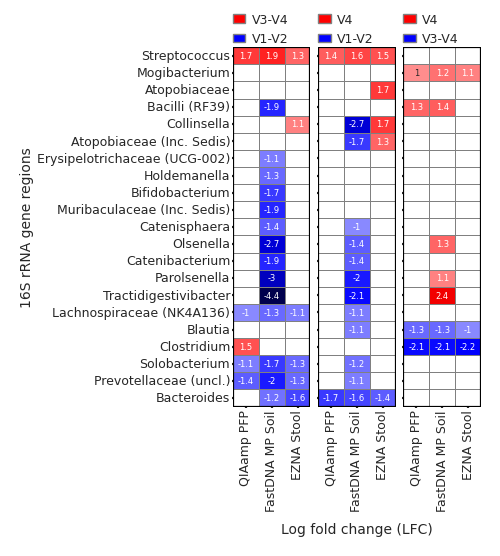

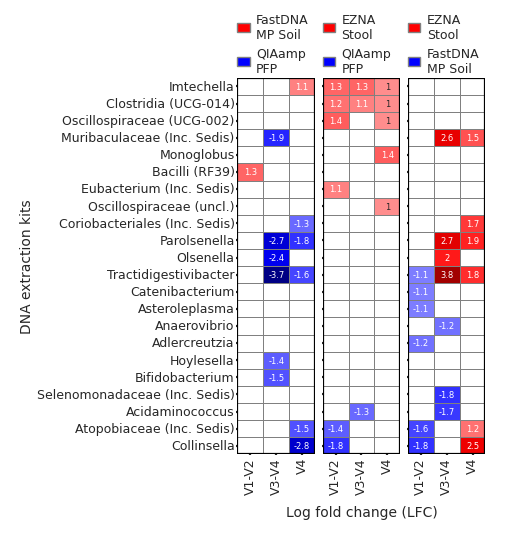

In [12]:
def aesthetics(ax, ylen, xlen):
    ax.axhline(y=0, color='k',linewidth=.8)
    ax.axhline(y=ylen, color='k',linewidth=.8)
    ax.axvline(x=0, color='k',linewidth=.8)
    ax.axvline(x=xlen, color='k',linewidth=.8)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(rotation=0, axis='both', labelsize=4.5, length=.5, pad=.5)
    ax.tick_params(rotation=90, axis='x', labelsize=4.5,)
    

summ = pd.read_csv(f'{out}/ABC2.tsv', sep='\t')
summ.taxon = summ.taxon.str.replace('(uncl.) (UCG-002)', '(UCG-002)', regex=False)\
             .str.replace('s group', 's', regex=False)
summ.sort_values(by='LFC', ascending=False, inplace=True)
vmax, vmin = summ.LFC.max(), summ.LFC.min() #max and min values for cbar

#set figure
cols = 3
rows = 1

for st in LFCdict:
    xorder = subkits if st == list(LFCdict.keys())[0] else list(MDICT.keys())
    df = summ.loc[summ.Subtype == st].set_index('taxon').copy()
    grouped = pd.DataFrame(df.groupby('taxon')['LFC'].sum())
    grouped.sort_values(by='LFC', ascending=False, inplace=True)
    yorder = grouped.index.unique().tolist()
    
    #set fig scaling
    S = 9
    H = len(yorder)/S #height of figure
    W = 1.6 #width of figure
    step = 1/len(yorder) #height of 1 line
    
    fig, axes = plt.subplots(rows, cols, figsize=(W, H), sharey='row', 
                             gridspec_kw={'wspace': .1})
    
    for i, (p1, p2) in enumerate(LFCdict[st]):
        p2 = "_V4" if p2 == 'V4' else p2
        data = df.loc[(df.Pair.str.contains(p1)) & (df.Pair.str.contains(p2))].copy()
        #display(data)
        hdf = data.pivot(columns=['Group'], values='LFC')

        #fix columns
        for c in xorder:
            if c not in hdf.columns:
                hdf[c] = np.nan
        hdf = hdf[xorder]

        #fix rows
        for ind in yorder:
            if ind not in hdf.index:
                hdf.loc[ind, :] = np.nan
        hdf = hdf.reindex(yorder)

        #plot
        ax = axes[i]
        hdf = hdf.round(1)
        sns.heatmap(data=hdf, ax=ax, annot=True, cbar=False, square=False, center=0, cmap='seismic',
                    xticklabels=True, yticklabels=True, annot_kws={"size":3}, 
                    linewidths=.3, linecolor='grey', vmax=vmax, vmin=vmin)

        #aesthetics
        aesthetics(ax, len(yorder), len(xorder))
        if i == 0:
            ax.set_ylabel(st, fontsize=5, labelpad=1)
        if i == 1:
            ax.set_xlabel('Log fold change (LFC)', fontsize=5)
            

        #legend
        p2 = "V4" if p2 == '_V4' else p2
        ypos = -2 if '16S' in st else -3.8
        labs = [p2, p1]
        hans = [mpatches.Patch(color='red' if l == p2 else 'blue', ec='grey', lw=.5) for l in labs]
        labs = [p2.replace(' ', '\n').replace('P\nS', 'P S'), p1.replace(' ', '\n').replace('P\nS', 'P S')]

        ax.legend(hans, labs, loc=2, fontsize=4.5, frameon=False, bbox_to_anchor=(0, ypos), borderpad=-.5, 
                  bbox_transform=ax.transData, ncol=1, columnspacing=1.5, handlelength=1, handletextpad=.5)
       
    plt.savefig(f'{out_figs}/ABC2_{st.split(" ")[0]}.svg')
    plt.savefig(f'{out_figs}/ABC2_{st.split(" ")[0]}.png')

# **Accuracy evaluation**

## Functions

In [11]:
# unpack
def get_accuracy(qza):
    a = !unzip {qza}
    out = a[1].split('/')[0].replace('  inflating: ','')
    fneg = pd.read_csv(f"{out}/data/false_negative_features.tsv", sep='\t')
    misc = pd.read_csv(f"{out}/data/misclassifications.tsv", sep='\t')
    undr = pd.read_csv(f"{out}/data/underclassifications.tsv", sep='\t')
    ress = pd.read_csv(f"{out}/data/results.tsv", sep='\t')
    !rm -rf {out}
    return fneg, misc, ress, undr


#parse formula. Borrowed from https://github.com/qiime2/q2-longitudinal
def parse_formula(formula): 
    from patsy import ModelDesc
    from statsmodels.formula.api import ols
    if '~' not in formula:
        raise ValueError('Formula not valid: missing tilde.\n')
    if ';' in formula or formula.strip()[0].isdigit():
        metric = formula.split('~')[0].strip()
    else: metric = None
    # use patsy to parse formula
    model_desc = ModelDesc.from_formula(formula)
    group_columns = set()
    for t in model_desc.rhs_termlist:
        for i in t.factors: 
            group_columns.add(i.name())
    if metric is None:
        metric = model_desc.lhs_termlist[0].name()
    return metric, group_columns


#anova
def run_anova(formula, data, pairs=False):
    import pandas as pd
    import statsmodels.api as sm
    from patsy import ModelDesc
    from statsmodels.formula.api import ols
    
    metric, group_columns = parse_formula(formula)
    columns  = [metric] + list(group_columns)
    cats = data.select_dtypes(exclude='number').columns.tolist()
    metadata = data[columns].dropna().copy()
    lm = ols(formula, metadata).fit()
    results = pd.DataFrame(sm.stats.anova_lm(lm, typ='II')).fillna('')
    # Run pairwise t-tests with multiple test correction
    pairwise_tests = pd.DataFrame()
    for group in group_columns:
        # only run on categorical columns — numeric columns raise error
        if group in cats:
            ttests = lm.t_test_pairwise(group, method='fdr_bh').result_frame
            pairwise_tests = pd.concat([pairwise_tests, pd.DataFrame(ttests)])
    if pairwise_tests.empty:
        pairwise_tests = False  
    # Plot fit vs. residuals
    metadata['residual'] = lm.resid
    metadata['fitted_values'] = lm.fittedvalues
    return results, pairwise_tests, metadata


renames = {
    'Observed / Expected Taxa': 'OET',
    'P value': 'P_value',
    'Std Err': 'StdErr',
    'Bray-Curtis': 'Bray_Curtis',
    'r-squared': 'r_squared',
    
}

facts = ['OET', 'TAR', 'TDR', 'Slope', 'P_value', 'StdErr', 'Bray_Curtis', 'Jaccard', 'r_squared']
abc2 = 'Results/ANCOM-BC2_regs'
out, out_figs = 'Results/CompEval', 'Figures/CompEval'

!mkdir -p {out} {out_figs}

## Prepare data

### Import averaged MG as expected composition (RA)

In [ ]:
for kit in CDICT:
    kit = kit.replace(' ', '_')

    #convert to RA
    data = pd.read_csv(f'{abc2}/{kit}_gen_table.tsv', sep='\t', index_col=0)
    meta = METAM.loc[(METAM.SID != 'TrueFecal Control')]
    data = data[[c for c in data.columns if c in meta.index]]
    data['Sum'] = data.sum(axis=1)
    data = data.loc[data.Sum != 0]
    data['MG'] = data.Sum/data.Sum.sum()
    df = pd.DataFrame(data['MG'])
    df.to_csv(f'{out}/{kit}_MG_table.tsv', sep='\t')

    #import
    !biom convert \
        -i {out}/{kit}_MG_table.tsv \
        -o {out}/{kit}_MG_table.biom \
        --table-type="OTU table" \
        --to-hdf5
    
    !qiime tools import \
        --type FeatureTable[RelativeFrequency] \
        --input-path {out}/{kit}_MG_table.biom \
        --output-path {out}/{kit}_MG_table.qza

### Import 16S rRNA data as RA

In [ ]:
for kit in CDICT:
    kit = kit.replace(' ', '_')

    #convert to RA
    data = pd.read_csv(f'{abc2}/{kit}_gen_table.tsv', sep='\t', index_col=0)
    meta = META.loc[(META.SID != 'TrueFecal Control')]
    data = data[[c for c in data.columns if c in meta.index]]
    data = data.div(data.sum(axis=0), axis=1)
    data.to_csv(f'{out}/{kit}_16S_table.tsv', sep='\t')

    #import
    !biom convert \
        -i {out}/{kit}_16S_table.tsv \
        -o {out}/{kit}_16S_table.biom \
        --table-type="OTU table" \
        --to-hdf5
    
    !qiime tools import \
        --type FeatureTable[RelativeFrequency] \
        --input-path {out}/{kit}_16S_table.biom \
        --output-path {out}/{kit}_16S_table.qza

!rm {out}/*.biom 

### Metadata

In [40]:
for kit in CDICT:
    KIT = kit.replace(' ', '_')
    data = pd.read_csv(f'{out}/{KIT}_16S_table.tsv', sep='\t', index_col=0)
    meta = META.loc[(META.Kit == kit) & (META.SID != 'TrueFecal Control')]
    meta = meta.loc[[i for i in meta.index if i in data.columns]]
    meta = meta[['Kit', 'Region', 'SID']]
    meta['Expected'] = 'MG'
    meta.to_csv(f'{out}/{KIT}_md.tsv', sep='\t')

## Evaluate composition

### Run evaluate-composition

In [ ]:
for kit in CDICT:
    kit = kit.replace(' ', '_')

    #composition accuracy
    !qiime quality-control evaluate-composition \
        --i-expected-features {out}/{kit}_MG_table.qza \
        --i-observed-features {out}/{kit}_16S_table.qza \
        --p-depth 1 \
        --m-metadata-file {out}/{kit}_md.tsv \
        --m-metadata-column Expected \
        --o-visualization {out}/{kit}_accuracy.qzv

### Extract and merge outputs

In [ ]:
dfs = {
    'fneg': [],
    'misc': [],
    'ress': [],
    'undr': [],
}

for kit in CDICT:
    KIT = kit.replace(' ', '_')    
    qzv = f"{out}/{KIT}_accuracy.qzv"
    fneg, misc, ress, undr = get_accuracy(qzv)
    unpacked = [fneg, misc, ress, undr]
    for i, k in enumerate(list(dfs.keys())):
        df = unpacked[i]
        df['Kit'] = kit
        dfs[k].append(df)

for k, v in dfs.items():
    df = pd.concat(v, ignore_index=True).fillna(0)
    df = df[['Kit'] + [c for c in df.columns if c != 'Kit']]
    if k == 'ress':
        df['Region'] = df['sample'].str.rsplit('-', 1).str[-1].str.replace('V1', 'V1-V').str.replace('V3', 'V3-V')
    df.to_csv(f'{out}/{k}_accuracy.tsv', sep='\t', index=False)


## Stats

### ANOVA

In [ ]:
ress = pd.read_csv(f'{out}/ress_accuracy.tsv', sep='\t', index_col='sample')
ress = ress.rename(columns=renames)
ress.Region = ress.Region.str.replace('-', '_')
anova, pairwise, residuals = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for kit in CDICT:
    for fact in facts:
        data = ress[(ress[fact].notna()) & (ress.Kit==kit)].copy()
        formula= f'{fact} ~ Region'
        results, pairwise_tests, data = run_anova(formula, data)
        results['Metric'] = pairwise_tests['Metric'] = data['Metric'] = fact
        results['Factor'] = pairwise_tests['Factor'] = data['Factor'] = 'Region'
        results['Kit'] = pairwise_tests['Kit'] = data['Kit'] = kit
        anova = pd.concat([anova, results])
        pairwise = pd.concat([pairwise, pairwise_tests])
        residuals = pd.concat([residuals, data])
anova.to_csv(f'{out}/anova.tsv', sep='\t')
pairwise.to_csv(f'{out}/anova_pairs.tsv', sep='\t')
residuals.to_csv(f'{out}/anova_residuals.tsv', sep='\t')
display(anova)

### Descriptive stats

In [ ]:
ress = pd.read_csv(f'{out}/ress_accuracy.tsv', sep='\t', index_col='sample')
ress = ress.rename(columns=renames)
dfs = []
for reg in MDICT:
    for kit in CDICT:
        for fact in facts:
            data = ress[(ress[fact].notna()) & (ress.Kit==kit) & (ress.Region==reg)].copy()
            desc = pd.DataFrame(data[fact].describe()).T.reset_index(names='Factor')
            desc[['Kit', 'Region']] = kit, reg
            dfs.append(desc)
    
df = pd.concat(dfs, ignore_index=True)
df = df[[c for c in df.columns if '%' not in c]]
df['mean'] = df['mean'].apply(lambda x: round(x, 3))
df['std'] = df['std'].apply(lambda x: round(x, 3))
df.to_csv(f'{out}/Descriptive.tsv', sep='\t', index=False)
display(df)

In [ ]:
MDICT

## Plot accuracy

/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/cld4py/cld4py.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[vals] = data[vals].apply(pd.to_numeric)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/cld4py/cld4py.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[vals] = data[vals].apply(pd.to_numeric)
/home/ty/miniforge3/envs/qiime2-amplicon-2025.4/lib/python3.10/site-packages/cld4py/cld4py.py:44: SettingWithCopyWarning: 
A value is 

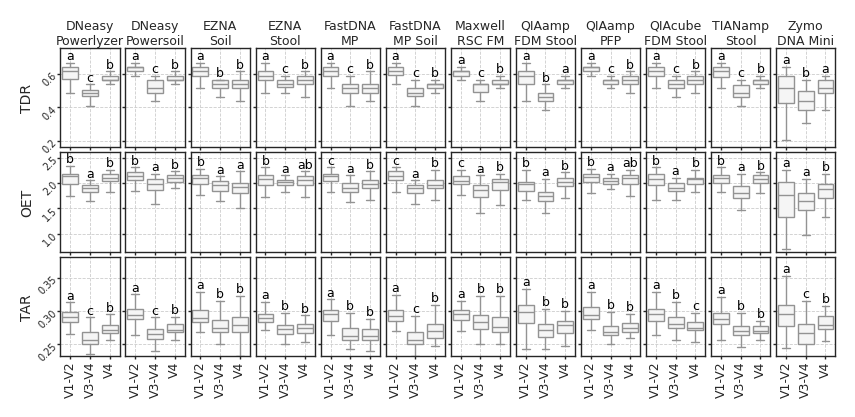

In [16]:
ABCsort = {
    'TDR': 'descending',
    "OET": 'ascending',
    'TAR': 'descending', }
    #'Bray_Curtis': 'ascending',
    #'P_value': None, 
    #'r_squared': None,}

pairs = pd.read_csv(f'{out}/anova_pairs.tsv', sep='\t')
pairs[['Group1', 'Group2']] = pairs['Unnamed: 0'].str.split('-', expand=True)
for col in ['Group1', 'Group2']:
    pairs[col] = pairs[col].str.replace('_', '-')
ress = pd.read_csv(f"{out}/ress_accuracy.tsv", sep='\t', index_col='sample')
ress = ress.rename(columns=renames)
dfs = []
cols = len(CDICT)
rows = len(ABCsort)
fig, axes = plt.subplots(rows, cols, figsize=(5, 2), sharey='row',
                         gridspec_kw={'hspace': .05, 'wspace': .1})
axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0

for fact in ABCsort:
    for kit in CDICT:
        ax, i = axes[axs[i][0]][axs[i][1]], i+1
        data = ress[(ress[fact].notna()) & (ress['Kit'] == kit)]
    
        ### Boxplots ###
        sns.boxplot(x='Region', y=fact, data=data, ax=ax, order=MDICT, linewidth=0.5, 
                    showfliers=False, color='whitesmoke',)
        
        ax.tick_params(axis='both', labelsize=3.5, length=1, pad=-.5, width=0.5,rotation=45 )
        ax.tick_params(axis='x', labelsize=4.5, rotation=90, pad=.5)
        ax.yaxis.offsetText.set_fontsize(3.5)
        ax.yaxis.offsetText.set_position((-.3,5))
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.grid(lw=.3, ls='--')
        if kit == list(CDICT.keys())[0]:
            label = fact.replace('_', '-').replace('r-squared', 'r$^2$-val.')
            ax.set_ylabel(label, fontsize=5, labelpad=1)
        if fact == list(ABCsort.keys())[0]:
            ax.text(.5, 1.04, kit.replace(' ', '\n').replace('\nFM', ' FM').replace('A\nMi', 'A Mi')\
            .replace('DM\nS', 'DM S').replace('P\nSo', 'P So'), ha='center', fontsize=4.5, transform=ax.transAxes)
        if fact == 'P_value':
            ax.set_ylim(-.02, .1)
            ax.axhline(y=0.05, color='red', linestyle='-', zorder=.8, lw=.5, alpha=1)
        if fact not in ['P_value', 'r_squared']:
            #cld
            statsdf = pairs.loc[(pairs.Kit == kit) & (pairs.Metric == fact)].copy()
            #display(statsdf)
            lim = 2
            if i >= 24:
                lim = 5
            if i >= 36:
                lim=3
            cld = cld4py.assign_letters(statsdf, 'Group1', 'Group2', 'pvalue-fdr_bh', 
                  order=ABCsort[fact], data=data, vals=fact, group='Region', param=True)
            #display(cld)
            cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='boxplot', pos='upper', 
                       vals=fact, group='Region', pad=1, c='black', fs=4.5, lim=lim)
        if kit == list(CDICT.keys())[-1] and i < 36:
            ymin, ymax = ax.get_ylim()
            ax.set_ylim(ymin*.4, ymax)

            
fig.align_labels()
plt.savefig(f'{out_figs}/Accuracy.svg')
plt.savefig(f'{out_figs}/Accuracy.png')

# **Spike-in**

## Functions

In [8]:
def bar_unzip(qza, lev):    
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ', '')
    inf = digest + f'/data/level-{lev}.csv'
    data = pd.read_csv(inf, sep=',', index_col=0, low_memory=False)
    !rm -rf $digest
    return data


regs = {
    'V1-V2': ['AGRGTTHGATYMTGGCTCAG', 'TGCTGCCTCCCGTAGGAGT'],
    'V3-V4': ['ACTCCTACGGGAGGCAGCAG', 'GGACTACHVGGGTWTCTAAT'],
    'V4': ['GTGCCAGCMGCCGCGGTAA', 'GGACTACHVGGGTWTCTAAT'],
}

SiN = ['Imtechella halotolerans', 'Allobacillus halotolerans']
queries = [s.split(' ')[0]+';' for s in SiN] + SiN
out_stats, out_figs = 'Results/SpikeIn', 'Figures/SpikeIn'

!mkdir -p {out_stats} {out_figs}

## IA ratios

In [ ]:
dfs = []

for reg in POOL:
    #data
    meta = METAM if reg == 'MG' else META
    lev = 8 if reg == 'MG' else 7
    df = bar_unzip(f'Results/Taxabarplots/{reg}_taxabarplot.qzv', lev)
    df = df[[c for c in df.columns if 'Imtechella halotolerans' in c \
             or 'Allobacillus halotolerans' in c or 'Imtechella_halotolerans' in c \
            or 'Allobacillus_halotolerans' in c]]
    if len(df.columns) > 2:
        display(reg, df)
    df.columns = [c.split('__')[-1].replace('_', ' ') for c in df.columns]
    if len(df.columns) == 2:
        df['Imtechella-/Allobacillus halotolerans ratio'] = df['Imtechella halotolerans'] / df['Allobacillus halotolerans']
    df['Region'] = reg
    df[['SID', 'Kit']] = meta[['SID', 'Kit']]
    dfs.append(df)
    
IA = pd.concat(dfs)
IA.to_csv(f'{out_stats}/IA_ratios.tsv', sep='\t')
IA

## Plot IA ratios

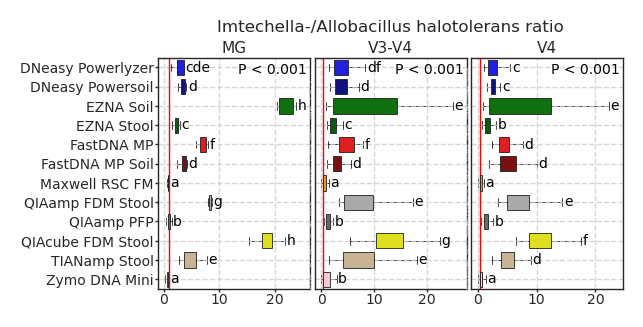

In [48]:
opt = [1, 0.43, 0.43]   #1/1 for MG and 3/7 for 16S copies
col = 'Imtechella-/Allobacillus halotolerans ratio'
IA = pd.read_csv(f'{out_stats}/IA_ratios.tsv', sep='\t', index_col=0)
IA.replace([np.inf, -np.inf], np.nan, inplace=True)
IA.dropna(subset=[col], how="all", inplace=True)
summary = pd.DataFrame()

#set figure
cols = 3
rows = 1
i = 0
fig, axes = plt.subplots(rows, cols, figsize=(3, 1.5), 
                         gridspec_kw={'wspace': .03})

for reg in POOL:
    if reg == 'V1-V2':
        continue  
    data = IA.loc[IA.Region == reg].copy()
        
    # boxplots
    ax, i = axes[i], i+1
    sns.boxplot(y='Kit', x=col, data=data, ax=ax, zorder=-i,
            linewidth=0.3, palette=CDICT, showfliers=False, order=CDICT)
    if i == 2:
        ax.text(.5, 1.1, col, ha='center', fontsize=6, transform=ax.transAxes, va='bottom')
    ax.tick_params(axis='both', labelsize=5, pad=.5, length=1, width=0.5 )
    #ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(lw=.5, ls='--', alpha=0.8) 
    ax.text(.5, 1.01, reg, va='bottom', ha='center', fontsize=5.5, transform=ax.transAxes, )
    ax.axvline(x=opt[i-1], color='red', linestyle='-', zorder=.8, lw=.5, alpha=1)
    if i > 1:
        ax.tick_params(axis='y',labelsize=0, colors='white', rotation=90, pad=0, length=0)
        
    #stats
    kw, phoc = kw_wx_test(data, 'Kit', col, 'SID', pairwise=True)
    if kw[1] < 0.05:
        for ind in phoc.index:
            j = len(summary)
            summary.loc[j, ['Metric', 'Region']] = col, reg
            summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
            summary.loc[j, ['Group1', 'Group2']] = phoc.loc[ind, ['Group1', 'Group2']]
            summary.loc[j, ['p', 'q']] = phoc.loc[ind, ['p', 'q']]
    else:
        j = len(summary)
        summary.loc[j, ['Metric', 'Region']] = col, reg
        summary.loc[j, ['KW_WX', 'Stats']] = kw[1], kw[0]
        summary.loc[j, ['Group1', 'Group2', 'p', 'q']] = '-', '-', '-', '-'
        
    # add P-general
    summ = summary.loc[summary.Region == reg]
    p_gen = round(summ.KW_WX.iloc[0], 3)
    p = f'P = {p_gen}'
    if p_gen == 0:
        p = f'P < 0.001'
    c = 'black' if p_gen < .05 else 'dimgrey'
    ax.text(.98, .98, p, va='top', ha='right', fontsize=5, transform=ax.transAxes, c=c)
    
    #cld
    summ = summ.loc[summ.q != '-']
    cld = cld4py.assign_letters(summ, 'Group1', 'Group2', 'q', order='ascending', 
                                data=data, vals=col, group='Kit', param=False)
    cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='y', plot='boxplot', pos='upper', 
               vals=col, group='Kit', pad=1, c='black', fs=5, lim=5)

summary.to_csv(f'{out_stats}/KW_WX_IA_Ratios_dependent.tsv', sep='\t')
plt.savefig(f'{out_figs}/IA_Ratios.svg')
plt.savefig(f'{out_figs}/IA_Ratios.png')

### Descriptive stats

In [ ]:
dfs = []
col = 'Imtechella-/Allobacillus halotolerans ratio'
IA = pd.read_csv(f'{out_stats}/IA_ratios.tsv', sep='\t', index_col=0)
IA.replace([np.inf, -np.inf], np.nan, inplace=True)
IA.dropna(subset=[col], how="all", inplace=True)

for reg in POOL:
    if reg == 'V1-V2':
        continue  
    for kit in CDICT:
        data = IA.loc[(IA.Region == reg) & (IA.Kit == kit)].copy()
        desc = pd.DataFrame(data[col].describe()).T.reset_index(names='Factor')
        desc[['Region', 'Kit']] = reg, kit
        dfs.append(desc)
    
df = pd.concat(dfs, ignore_index=True)
df['mean'] = df['mean'].apply(lambda x: round(x, 3))
df['median'] = df['50%'].apply(lambda x: round(x, 3))
df['IQR'] = df['75%'] - df['25%']
df['IQR'] = df['IQR'].apply(lambda x: round(x, 3))
df['std'] = df['std'].apply(lambda x: round(x, 3))
df = df[[c for c in df.columns if '%' not in c]]
df.to_csv(f'{out_stats}/IA_ratios_Descriptive.tsv', sep='\t', index=False)
display(df)

## Primer specificity

### Extract reads

In [ ]:
#extract reads
#!qiime tools export \
#    --input-path {CLASS}/seqs.qza \
#    --output-path {out_stats}/Silva-seqs

perc = [95, 90, 80]
for per in perc:
    for reg in regs:
        fwd, rvs = regs[reg]

        !qiime feature-classifier extract-reads \
            --i-sequences {CLASS}/seqs.qza \
            --p-f-primer {fwd} \
            --p-r-primer {rvs} \
            --p-read-orientation 'both' \
            --p-identity {per} \
            --o-reads {out_stats}/{reg}-{per}-seqs.qza \
            --p-n-jobs 16 

        !qiime tools export \
            --input-path {out_stats}/{reg}-{per}-seqs.qza \
            --output-path {out_stats}/{reg}-{per}-seqs

### Count Spikeins in Silva DB

In [ ]:
queries = [s.split(' ')[0]+';' for s in SiN] + SiN
seqs = ['Silva'] + list(MDICT.keys())
    
perc = [95, 90, 80]

for per in perc:
    summ = pd.DataFrame(index=queries)
    for seq in seqs:
        summ[seq] = 0
        file = f'{out_stats}/{seq}-seqs/dna-sequences.fasta'
        if seq != seqs[0]:
            file = f'{out_stats}/{seq}-{per}-seqs/dna-sequences.fasta'
        with open(file, 'r') as DB:
            DB = DB.read()
            for s in queries:
                summ.loc[s, seq] += DB.count(s)

    summ.index = summ.index.str.strip(';')                   
    summ.to_csv(f"{out_stats}/Spikin_extr_counts_{per}.tsv", sep='\t', )
    display(summ)

## Plot SpikeIn extracted counts

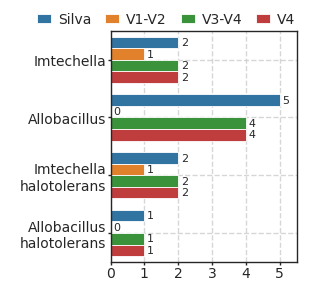

In [7]:
count = pd.read_csv(f"{out_stats}/Spikin_extr_counts_80.tsv", sep='\t', index_col=0)
count.index = count.index.str.replace(' ', '\n')
#set figure
rows = 1
cols = 1

fig, ax = plt.subplots(rows, cols, figsize=(1.2, 1.5))

data = count.melt(ignore_index=False).reset_index()
sns.barplot(x='value', y='index', data=data, ax=ax, linewidth=0.3, 
            hue='variable', order=count.index)

ax.tick_params(axis='both', labelsize=5, pad=.5, length=1, width=0.5 )
#ax.tick_params(axis='x', labelsize=5, rotation=90)
ax.set_ylabel('', fontsize=6, labelpad=2)
ax.set_xlabel('', fontsize=6, labelpad=2)
ax.set_xlim(0, data['value'].max()*1.1)
xx = range(7)
ax.set(xticks=np.arange(min(xx), max(xx)))
ax.grid(lw=.5, ls='--', alpha=0.8,)
for i, container in enumerate(ax.containers):
    ax.bar_label(container, fmt='%.0f', fontsize=4, padding=1, )

#legend
ax.legend().remove()
hans, labs = ax.get_legend_handles_labels()

ax.legend(hans, labs, loc=9, fontsize=5, frameon=False, bbox_to_anchor=(0.3, 1.08), borderpad=-.5, 
          bbox_transform=ax.transAxes, ncol=4, columnspacing=1, handlelength=1, handletextpad=.5)
       
plt.savefig(f'{out_figs}/Spikin_extr_counts.svg')
plt.savefig(f'{out_figs}/Spikin_extr_counts.png')